The aim of this notebook is to conduct EDA on our dataset and to build a baseline classification model to predict home wins. The dataset was generated by first scraping up to 10 years of league, domestic cup, and continental cup fixtures. The data conerns team performance only. The odds data was taken as an average of six bookmakers. From this initial dataset we have calculated moving averages, ratios, and poisson statistics among other variables which we feel might have predictive power. The dataset will necessarily contains many NaN rows which need to be discarded as we have used moving averages. In addition to this, some of the scraping functions did not complete as expected and certain variables are unavilable. 

First we clean the data of NaN values, then we conduct EDA to establish certain facts about our dataset regarding distribution and correlations and then remove outliers. We then do some preprocessing and build a baseline model which we analyse for performance.

In [1]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Cleaning**

First we will remove some columns. Most of the columns removed are columns which provide insight into the results we want to predict. These are the variables that contain statistics from the current fixture, which were used to engineer other features such as moving averages, ratios, and poisson statistics among others. Other columns contain either incorrect, incomplete or irrelevent information.

In [2]:
df = pd.read_csv(r"C:\Users\kiera\Downloads\ratios_and_accuracy_stats_df.csv")

In [3]:
list(df.columns)

['Unnamed: 0',
 'Unnamed: 0.1',
 'Unnamed: 0.1.1',
 'Unnamed: 0.1.1.1',
 'Unnamed: 0.1.1.1.1',
 'Unnamed: 0.1.1.1.1.1',
 'Unnamed: 0.1.1.1.1.1.1',
 'level_0',
 'index',
 'Home',
 'Away',
 'Home Score',
 'Away Score',
 'Date',
 'Home Ball Possession',
 'Away Ball Possession',
 'Home Goal Attempts',
 'Away Goal Attempts',
 'Home Shots on Goal',
 'Away Shots on Goal',
 'Home Shots off Goal',
 'Away Shots off Goal',
 'Home Corner Kicks',
 'Away Corner Kicks',
 'First Half Home Goals',
 'First Half Away Goals',
 '2nd Half Home Goals',
 '2nd Half Away Goals',
 'Home Lineup',
 'Away Lineup',
 'Home Team Full Time Odds',
 'Draw Full Time Odds',
 'Away Team Full Time Odds',
 'Over 2.5 Full Time Odds',
 'Under 2.5 Full Time Odds',
 'BTS Yes Full Time Odds',
 'BTS No Full Time Odds',
 'Home 1st Half Ball Possession',
 'Away 1st Half Ball Possession',
 'Home 1st Half Goal Attempts',
 'Away 1st Half Goal Attempts',
 'Home 1st Half Shots on Goal',
 'Away 1st Half Shots on Goal',
 'Home 1st Half Shot

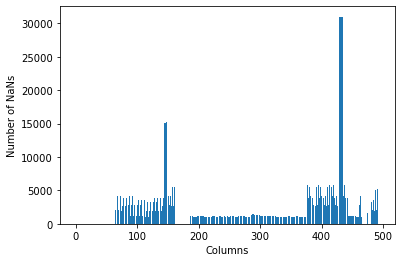

In [4]:
# Create a Series of NaN counts for each column
nan_counts = df.isna().sum()

# Create a histogram of the NaN counts
plt.bar(range(len(nan_counts)), nan_counts.values)
plt.xlabel('Columns')
plt.ylabel('Number of NaNs')
plt.show()

In [5]:
threshold = 10000 

for col in df.columns:
    num_nans = df[col].isna().sum()
    if num_nans > threshold:
        print(f"{col}: {num_nans} NaN values")

PPG Home Last 3: 15147 NaN values
PPG Home Last 5: 15147 NaN values
PPG Home Last 8: 15147 NaN values
PPG Away Last 3: 15273 NaN values
PPG Away Last 5: 15273 NaN values
PPG Away Last 8: 15273 NaN values
Home Over 35 Ratio 3: 30976 NaN values
Home Over 35 Ratio 5: 30981 NaN values
Home Over 35 Ratio 8: 30984 NaN values
Away Over 35 Ratio 3: 30981 NaN values
Away Over 35 Ratio 5: 30985 NaN values
Away Over 35 Ratio 8: 30985 NaN values


In [6]:
df = df.drop(['Unnamed: 0',
               'Unnamed: 0.1',
               'Unnamed: 0.1.1',
               'Unnamed: 0.1.1.1',
               'Unnamed: 0.1.1.1.1', 
               'Unnamed: 0.1.1.1.1.1', 
               'Unnamed: 0.1.1.1.1.1.1', 
               'Home Win', 
               'Away Win', 
               'level_0', 
               'index', 
               'Home', 
               'Away', 
               'Date', 
               'Home Ball Possession', 
               'Away Ball Possession', 
               'Home Goal Attempts', 
               'Away Goal Attempts', 
               'Home Shots on Goal', 
               'Away Shots on Goal', 
               'Home Shots off Goal', 
               'Away Shots off Goal', 
               'Home Corner Kicks', 
               'Away Corner Kicks', 
               '2nd Half Home Goals', 
               '2nd Half Away Goals', 
               'Home Lineup', 
               'Away Lineup', 
               'Home 1st Half Ball Possession', 
               'Away 1st Half Ball Possession', 
               'Home 1st Half Goal Attempts', 
               'Away 1st Half Goal Attempts', 
               'Home 1st Half Shots on Goal', 
               'Away 1st Half Shots on Goal', 
               'Home 1st Half Shots off Goal', 
               'Away 1st Half Shots off Goal', 
               'Home 1st Half Corner Kicks', 
               'Away 1st Half Corner Kicks', 
               'Home 2nd Half Ball Possession', 
               'Away 2nd Half Ball Possession', 
               'Home 2nd Half Goal Attempts', 
               'Away 2nd Half Goal Attempts', 
               'Home 2nd Half Shots on Goal', 
               'Away 2nd Half Shots on Goal', 
               'Home 2nd Half Shots off Goal', 
               'Away 2nd Half Shots off Goal', 
               'Home 2nd Half Corner Kicks', 
               'Away 2nd Half Corner Kicks', 
               'Home Team Congestion 7', 
               'Home Team Congestion 14', 
               'Home Team Congestion 28', 
               'Away Team Congestion 7', 
               'Away Team Congestion 14', 
               'Away Team Congestion 28', 
               'Days Since Last Match Home', 
               'Home Over 35 Ratio 3', 
               'Home Over 35 Ratio 5', 
               'Home Over 35 Ratio 8', 
               'Away Over 35 Ratio 3', 
               'Away Over 35 Ratio 5', 
               'Away Over 35 Ratio 8', 
               'Days Since Last Match Away', 
               'home_goal_times', 
               'away_goal_times', 
               'home_fg', 
               'away_fg',
               'PPG Home Last 3',
               'PPG Home Last 5',
               'PPG Home Last 8',
               'PPG Away Last 3',
               'PPG Away Last 5',
               'PPG Away Last 8',], 
              axis=1)

df = df.dropna(axis=0)


We create some target variables. This script will be looking at classifying fixtures according to the target variable 'home_win'

In [7]:
df['home_win'] = (df['Home Score'] > df['Away Score']).astype(int)
df['draw'] = (df['Home Score'] == df['Away Score']).astype(int)
df['away_win'] = (df['Away Score'] > df['Home Score']).astype(int)
df['fhg'] = (df['First Half Home Goals'] + df['First Half Away Goals'] > 0).astype(int)
df['home_win_prob'] = (round(1 / df['Home Team Full Time Odds'], 2)).astype(float)
df['draw_prob'] = (round(1 / df['Draw Full Time Odds'], 2)).astype(float)
df['away_win_prob'] = (round(1 / df['Away Team Full Time Odds'], 2)).astype(float)
df['o25_prob'] = (round(1 / df['Over 2.5 Full Time Odds'], 2)).astype(float)
df['bts_prob'] = (round(1 / df['BTS Yes Full Time Odds'], 2)).astype(float)
df['home_goal'] = (df['Home Score'] > 0).astype(int)
df['away_goal'] = (df['Away Score'] > 0).astype(int)

After removing the NaN values, we do some processing on the columns presenting possession, odds, and goal time data. We are looking to have data ranging in scale from 0 to 1, so this processing will save us having to scale them later in a way that might delete information in the column.

In [8]:
for col in df.columns:
    if "Possession" in col:
        df[col] = df[col]/100

for col in df.columns:
    if "Odds" in col:
        df[col] = 1 / (df[col])

for col in df.columns:
    if "First Goal" in col:
        df[col] = round(((df[col]) / 90), 2)

**EDA**

We do some basic EDA on our dataset. First we look at the success bookmakers have in predicting outcomes in soccer matches.
We do this by counting the win % for each implied probability given by the odds with an interval of 0.01 or 1%.

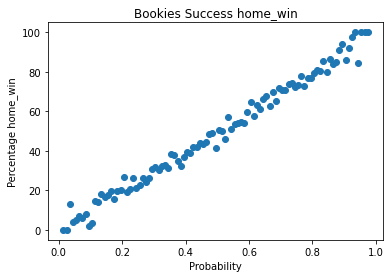

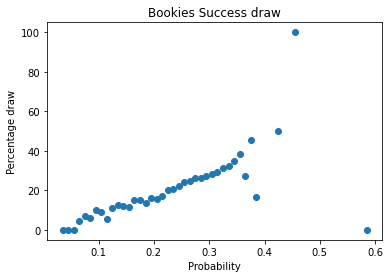

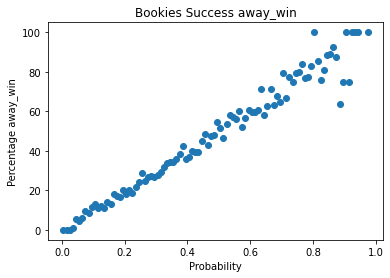

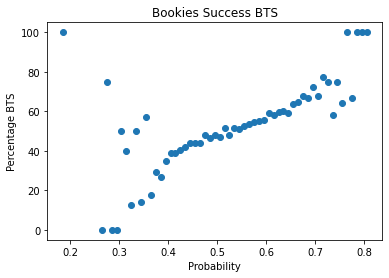

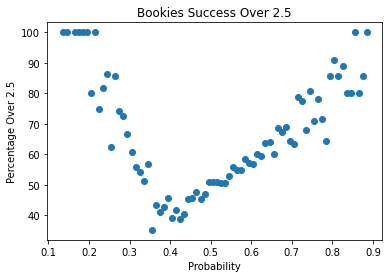

In [9]:
targets = ['home_win', 'draw', 'away_win', 'BTS', 'Over 2.5']
probs = ['home_win_prob', 'draw_prob', 'away_win_prob', 'bts_prob', 'o25_prob']

for col, prob in zip(targets, probs):
    # create 100 probability buckets
    buckets = np.linspace(0, 1, 101)

    # assign each row to its corresponding probability bucket
    df['Bucket'] = pd.cut(df[f'{prob}'], bins=buckets, include_lowest=True)

    # calculate the percentage of home wins for each bucket
    freq = df.groupby('Bucket')[f'{col}'].sum() / df.groupby('Bucket')[f'{col}'].count() * 100

    # create a scatter plot of percentage of BTS vs bucket midpoint
    midpoints = (buckets[:-1] + buckets[1:]) / 2
    plt.scatter(midpoints, freq)

    # set the x and y axis labels
    plt.xlabel('Probability')
    plt.ylabel(f'Percentage {col}')

    # set the title of the plot
    plt.title(f'Bookies Success {col}')

    # display the plot
    plt.show()

These charts make it clear that the win draw loss markets are very efficient. There is a strong correlation between the implied probability for all three outcomes and their true rate. However we do see that the tightness of the line in the chart for *'away_win'* for outsiders which slackens for favourites playing away from home.

The market for BTS is much less efficient. For those games with probability between 0.45 and 0.6 we see a good, bunched line- but great variance at both extremes. The same is true for the over 2.5 market. This suggests that there is perhaps greater opportunity for a model to beat the bookmakers in these markets than in the traditional WDL market.

Continuing on, we look at the distribution of our target variables. 

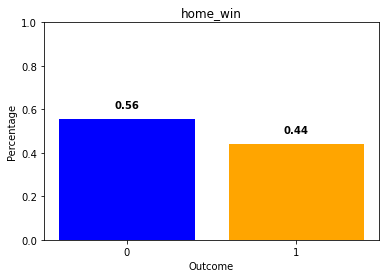

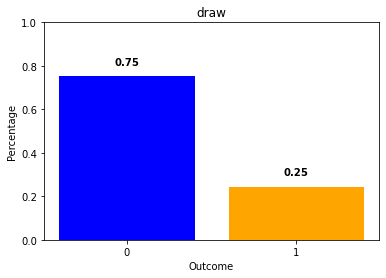

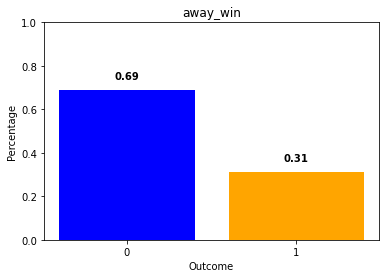

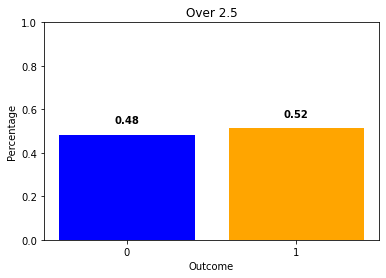

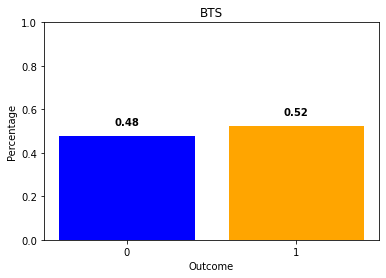

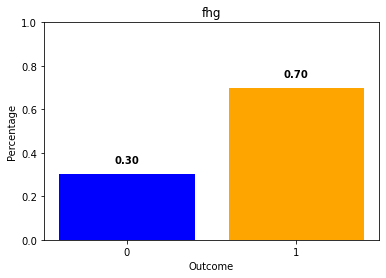

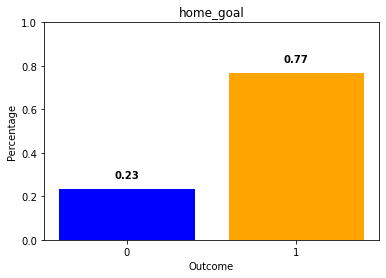

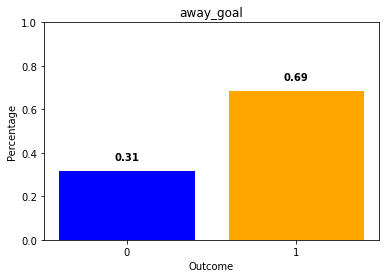

In [10]:
target_vars = ['home_win', 'draw', 'away_win', 'Over 2.5', 'BTS', 'fhg', 'home_goal', 'away_goal']
labels = ['0', '1']

for var in target_vars:
    counts = df[var].value_counts(normalize=True).sort_index()
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title(var)
    plt.xlabel('Outcome')
    plt.ylabel('Percentage')
    plt.ylim([0, 1])

    for i, count in enumerate(counts):
        plt.text(i, count+0.05, f'{count:.2f}', ha='center', fontweight='bold')

    plt.show()

We have imbalance in all of our WDL targets and a nice balance in Over 2.5 and BTS. For this script we are looking at home_win which has a 44% success rate. We can implement random oversampling to account for this, or use weighted classes when creating our model. We will look at both. 

For later regression models, we look at the distribution of our non binary discrete targets, total goals, home score, and away score. All three targets have a positive skew. We will remove the outliers in these columns and forget about this for now, however.

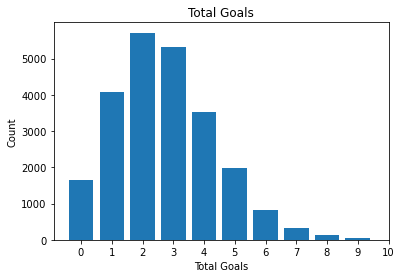

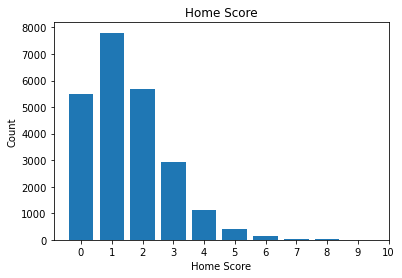

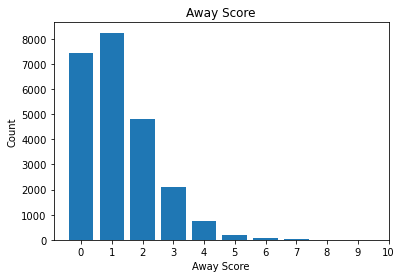

In [11]:
target_vars = ['Total Goals','Home Score', 'Away Score']
bins = range(11)

for var in target_vars:
    counts, _ = np.histogram(df[var], bins=bins)
    plt.bar(bins[:-1], counts)
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(range(11))


    plt.show()

In [12]:
# remove outliers

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

targets = ['draw', 'away_win', 'fhg', 'home_goal', 'away_goal', "Total Goals", "Over 2.5",
           "away_win_prob",'home_win_prob', "Home Score", "Away Score",
           "fhg", "First Half Home Goals", "First Half Away Goals", "Bucket"]

for col in numeric_cols:
    if col in targets:
        continue
    mean = df[col].mean()
    std_dev = df[col].std()
    threshold = mean + (4 * std_dev)
    outliers = df.loc[df[col] > threshold]
    df = df.loc[df[col] <= threshold]

We have a few categorical columns. 'Country' and 'League' that the fixture was taking place in, and the names of the Home and Away teams. We also have a date time variable in 'Kickoff'. We want to know if these variables might be useful for building a preditive model later. If any of the string categorical columns are useful, we can create an embedding layer and use the resulting embeddings in place of the categories. To see if they might have any predictive power, we conduct t-tests on the means of total goals, and home win rate for each country and league.

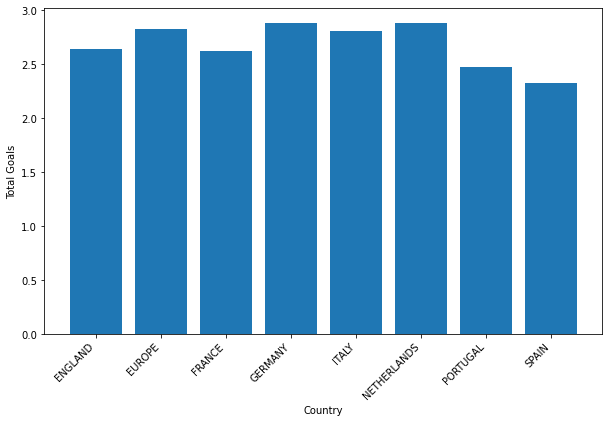

ENGLAND vs others: p = 0.6671
EUROPE vs others: p = 0.4551
FRANCE vs others: p = 0.2895
GERMANY vs others: p = 0.8888
ITALY vs others: p = 0.2807
NETHERLANDS vs others: p = 0.4370
PORTUGAL vs others: p = 0.0001
SPAIN vs others: p = 0.0000


In [13]:
cat_col = 'Country' 
num_col = 'Total Goals' 

cat_groups = df.groupby(cat_col)
means = cat_groups[num_col].mean()

fig, ax = plt.subplots(figsize=(10, 6)) 
ax.bar(means.index, means.values)
ax.set_xlabel(cat_col)
ax.set_ylabel(num_col)

plt.xticks(rotation=45, ha='right')

plt.show()

# levene variance test
for cat_value in df[cat_col].unique():
    group1 = df[num_col][df[cat_col] == cat_value]
    group2 = df[num_col][df[cat_col] != cat_value]
    _, p = stats.levene(group1, group2)
    print(f"{cat_value} vs others: p = {p:.4f}")

In [14]:
for cat_value in df[cat_col].unique():
    if not cat_value in ['PORTUGAL', 'SPAIN']:
        group1 = df[num_col][df[cat_col] == cat_value]
        group2 = df[num_col]
        t, p = stats.ttest_ind(group1, group2, equal_var=True)
        print(f"{cat_value} vs others: t = {t:.2f}, p = {p:.4f}")
    else:
        group1 = df[num_col][df[cat_col] == cat_value]
        group2 = df[num_col]
        t, p = stats.ttest_ind(group1, group2, equal_var=False)
        print(f"{cat_value} vs others: t = {t:.2f}, p = {p:.4f}")

ENGLAND vs others: t = -2.75, p = 0.0060
EUROPE vs others: t = 3.02, p = 0.0025
FRANCE vs others: t = -2.60, p = 0.0093
GERMANY vs others: t = 6.41, p = 0.0000
ITALY vs others: t = 3.06, p = 0.0022
NETHERLANDS vs others: t = 2.59, p = 0.0095
PORTUGAL vs others: t = -5.37, p = 0.0000
SPAIN vs others: t = -8.33, p = 0.0000


The results of the t-test indicate that using embeddings in place of the countries may help increase the predictive power of our model when predictiong total goals scored. Each countries averages is distinct from the whole average. Let us see if the same is true for WDL percentages.

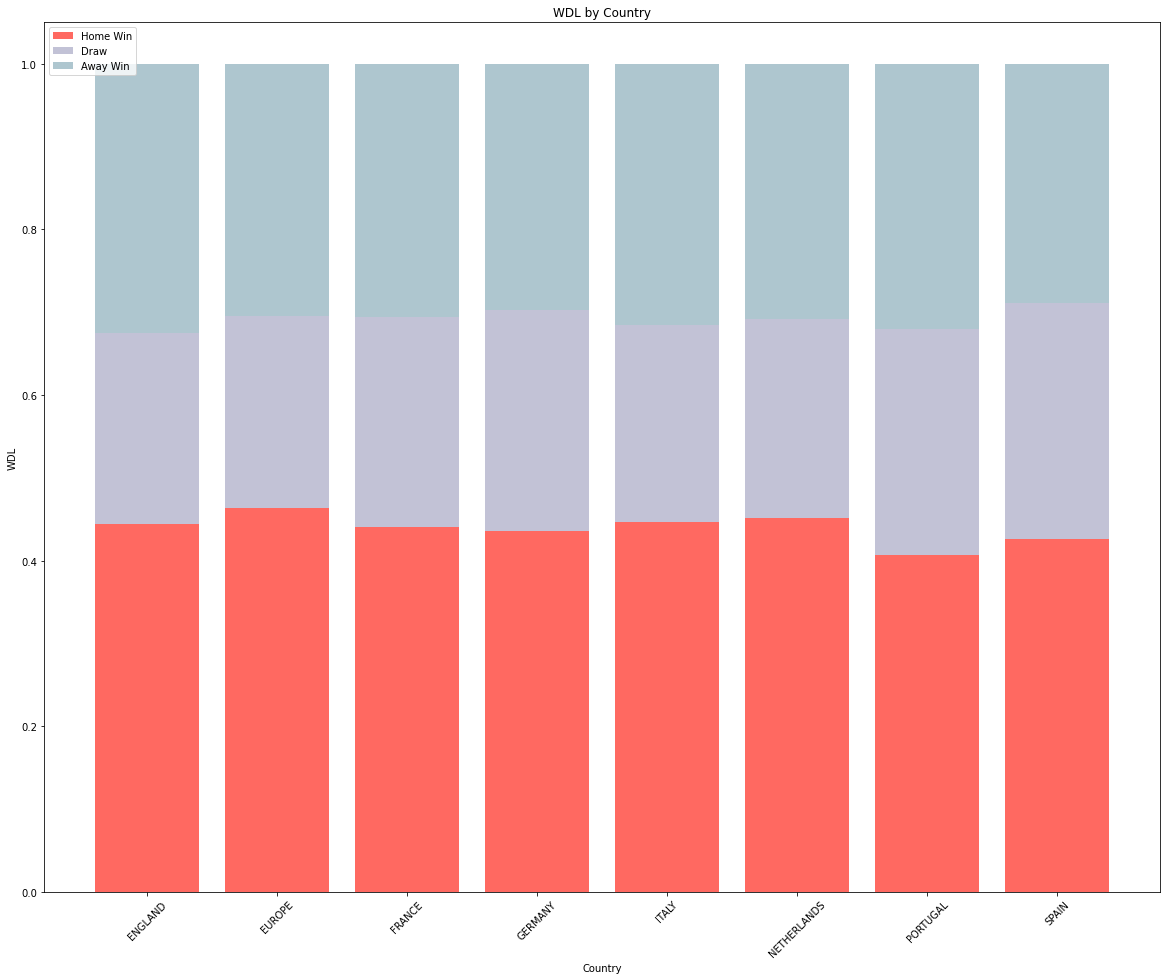

In [16]:
success_rates = []
for cat_value in df[cat_col].unique():
    home_win_group = df['home_win'][df[cat_col] == cat_value]
    draw_group = df['draw'][df[cat_col] == cat_value]
    away_win_group = df['away_win'][df[cat_col] == cat_value]
    home_win_rate = home_win_group.mean()
    draw_rate = draw_group.mean()
    away_win_rate = away_win_group.mean()
    success_rates.append((home_win_rate, draw_rate, away_win_rate))
    
    
# Create a bar plot of the success rates
fig, ax = plt.subplots(figsize=(20, 16))
colors = ['#ff6961', '#c2c2d6', '#aec6cf']
labels = ['Home Win', 'Draw', 'Away Win']

for i, (home_win_rate, draw_rate, away_win_rate) in enumerate(success_rates):
    total_rate = home_win_rate + draw_rate + away_win_rate
    home_win_length = home_win_rate / total_rate
    draw_length = draw_rate / total_rate
    away_win_length = away_win_rate / total_rate
    ax.bar(i, home_win_length, color=colors[0])
    ax.bar(i, draw_length, bottom=home_win_length, color=colors[1])
    ax.bar(i, away_win_length, bottom=home_win_length + draw_length, color=colors[2])

ax.set_xlabel(cat_col)
ax.set_ylabel('WDL')
ax.set_title('WDL by Country')
ax.set_xticks(range(len(df[cat_col].unique())))
ax.set_xticklabels(df[cat_col].unique(), rotation=45)
ax.legend(labels, loc='upper left')
plt.show()

In [20]:
same_var = []
print("Levene's Test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['home_win'][df[cat_col] == cat_value]
    group2 = df['home_win'][df[cat_col] != cat_value]

    # Perform a t-test on the means
    _, p = stats.levene(group1, group2)
    if p > 0.05:
        same_var.append(cat_value)
    
    print(f"{cat_value} vs others: p = {p:.4f}")

print("T-test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['home_win'][df[cat_col] == cat_value]
    group2 = df['home_win'][df[cat_col] != cat_value]
    
    # Compute the success rate for each group
    rate1 = group1.mean()
    rate2 = group2.mean()
    
    
    if not cat_value in same_var:
        _, p = stats.ttest_ind(group1, group2, equal_var=False)
    else:
        _, p = stats.ttest_ind(group1, group2, equal_var=True)
    
    print(f"{cat_value} vs others: Home Win rate = {rate1:.4f} vs {rate2:.4f}, p = {p:.4f}")

Levene's Test:
ENGLAND vs others: p = 0.4879
EUROPE vs others: p = 0.0493
FRANCE vs others: p = 0.9800
GERMANY vs others: p = 0.4538
ITALY vs others: p = 0.5024
NETHERLANDS vs others: p = 0.5942
PORTUGAL vs others: p = 0.0093
SPAIN vs others: p = 0.2839
T-test:
ENGLAND vs others: Home Win rate = 0.4449 vs 0.4397, p = 0.4879
EUROPE vs others: Home Win rate = 0.4632 vs 0.4391, p = 0.0504
FRANCE vs others: Home Win rate = 0.4410 vs 0.4412, p = 0.9800
GERMANY vs others: Home Win rate = 0.4362 vs 0.4425, p = 0.4538
ITALY vs others: Home Win rate = 0.4470 vs 0.4403, p = 0.5024
NETHERLANDS vs others: Home Win rate = 0.4517 vs 0.4409, p = 0.5942
PORTUGAL vs others: Home Win rate = 0.4068 vs 0.4434, p = 0.0087
SPAIN vs others: Home Win rate = 0.4256 vs 0.4420, p = 0.2839


In [21]:
same_var = []
print("Levene's Test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['away_win'][df[cat_col] == cat_value]
    group2 = df['away_win'][df[cat_col] != cat_value]

    # Perform a t-test on the means
    _, p = stats.levene(group1, group2)
    if p > 0.05:
        same_var.append(cat_value)
    
    print(f"{cat_value} vs others: p = {p:.4f}")

print("T-test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['away_win'][df[cat_col] == cat_value]
    group2 = df['away_win'][df[cat_col] != cat_value]
    
    # Compute the success rate for each group
    rate1 = group1.mean()
    rate2 = group2.mean()
    
    if not cat_value in same_var:
        _, p = stats.ttest_ind(group1, group2, equal_var=False)
    else:
        _, p = stats.ttest_ind(group1, group2, equal_var=True)
    
    print(f"{cat_value} vs others: Away Win rate = {rate1:.4f} vs {rate2:.4f}, p = {p:.4f}")

Levene's Test:
ENGLAND vs others: p = 0.0031
EUROPE vs others: p = 0.5509
FRANCE vs others: p = 0.4865
GERMANY vs others: p = 0.0228
ITALY vs others: p = 0.5580
NETHERLANDS vs others: p = 0.8609
PORTUGAL vs others: p = 0.4614
SPAIN vs others: p = 0.1126
T-test:
ENGLAND vs others: Away Win rate = 0.3257 vs 0.3050, p = 0.0033
EUROPE vs others: Away Win rate = 0.3047 vs 0.3115, p = 0.5509
FRANCE vs others: Away Win rate = 0.3057 vs 0.3118, p = 0.4865
GERMANY vs others: Away Win rate = 0.2968 vs 0.3146, p = 0.0215
ITALY vs others: Away Win rate = 0.3157 vs 0.3102, p = 0.5580
NETHERLANDS vs others: Away Win rate = 0.3077 vs 0.3110, p = 0.8609
PORTUGAL vs others: Away Win rate = 0.3200 vs 0.3103, p = 0.4614
SPAIN vs others: Away Win rate = 0.2894 vs 0.3121, p = 0.1126


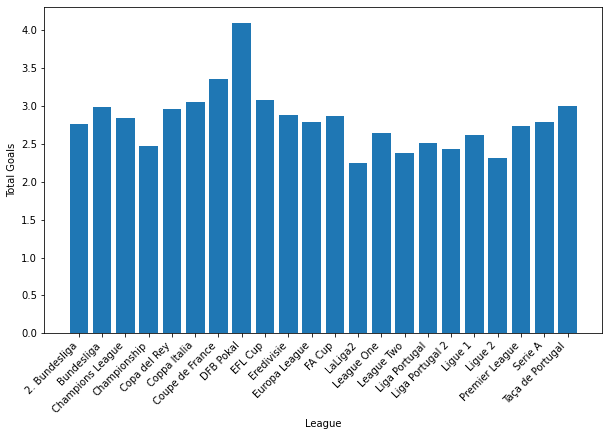

In [22]:
cat_col = 'League'  
num_col = 'Total Goals'

cat_groups = df.groupby(cat_col)
means = cat_groups[num_col].mean()

fig, ax = plt.subplots(figsize=(10, 6))  
ax.bar(means.index, means.values)
ax.set_xlabel(cat_col)
ax.set_ylabel(num_col)

# Rotate the x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.show()

In [23]:
cat_col = "League"
same_var = []
print("Levene's Test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['Total Goals'][df[cat_col] == cat_value]
    group2 = df['Total Goals'][df[cat_col] != cat_value]

    # Perform a t-test on the means
    _, p = stats.levene(group1, group2)
    if p > 0.05:
        same_var.append(cat_value)
    
    print(f"{cat_value} vs others: p = {p:.4f}")

print("T-test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['Total Goals'][df[cat_col] == cat_value]
    group2 = df['Total Goals'][df[cat_col] != cat_value]
    
    # Compute the success rate for each group
    rate1 = group1.mean()
    rate2 = group2.mean()
    
    
    if not cat_value in same_var:
        _, p = stats.ttest_ind(group1, group2, equal_var=False)
    else:
        _, p = stats.ttest_ind(group1, group2, equal_var=True)
    
    print(f"{cat_value} vs others: Total Goals = {rate1:.4f} vs {rate2:.4f}, p = {p:.4f}")

Levene's Test:
Championship vs others: p = 0.0001
EFL Cup vs others: p = 0.4574
FA Cup vs others: p = 0.4381
League One vs others: p = 0.6999
League Two vs others: p = 0.0060
Premier League vs others: p = 0.5832
Champions League vs others: p = 0.8848
Europa League vs others: p = 0.1556
Coupe de France vs others: p = 0.0416
Ligue 1 vs others: p = 0.2055
Ligue 2 vs others: p = 0.0005
2. Bundesliga vs others: p = 0.8793
Bundesliga vs others: p = 0.7669
DFB Pokal vs others: p = 0.9598
Coppa Italia vs others: p = 0.7692
Serie A vs others: p = 0.2383
Eredivisie vs others: p = 0.4370
Liga Portugal 2 vs others: p = 0.0007
Liga Portugal vs others: p = 0.0244
Taça de Portugal vs others: p = 0.5402
Copa del Rey vs others: p = 0.0517
LaLiga2 vs others: p = 0.0000
T-test:
Championship vs others: Total Goals = 2.4702 vs 2.7217, p = 0.0000
EFL Cup vs others: Total Goals = 3.0772 vs 2.6979, p = 0.0001
FA Cup vs others: Total Goals = 2.8627 vs 2.7015, p = 0.1202
League One vs others: Total Goals = 2.63

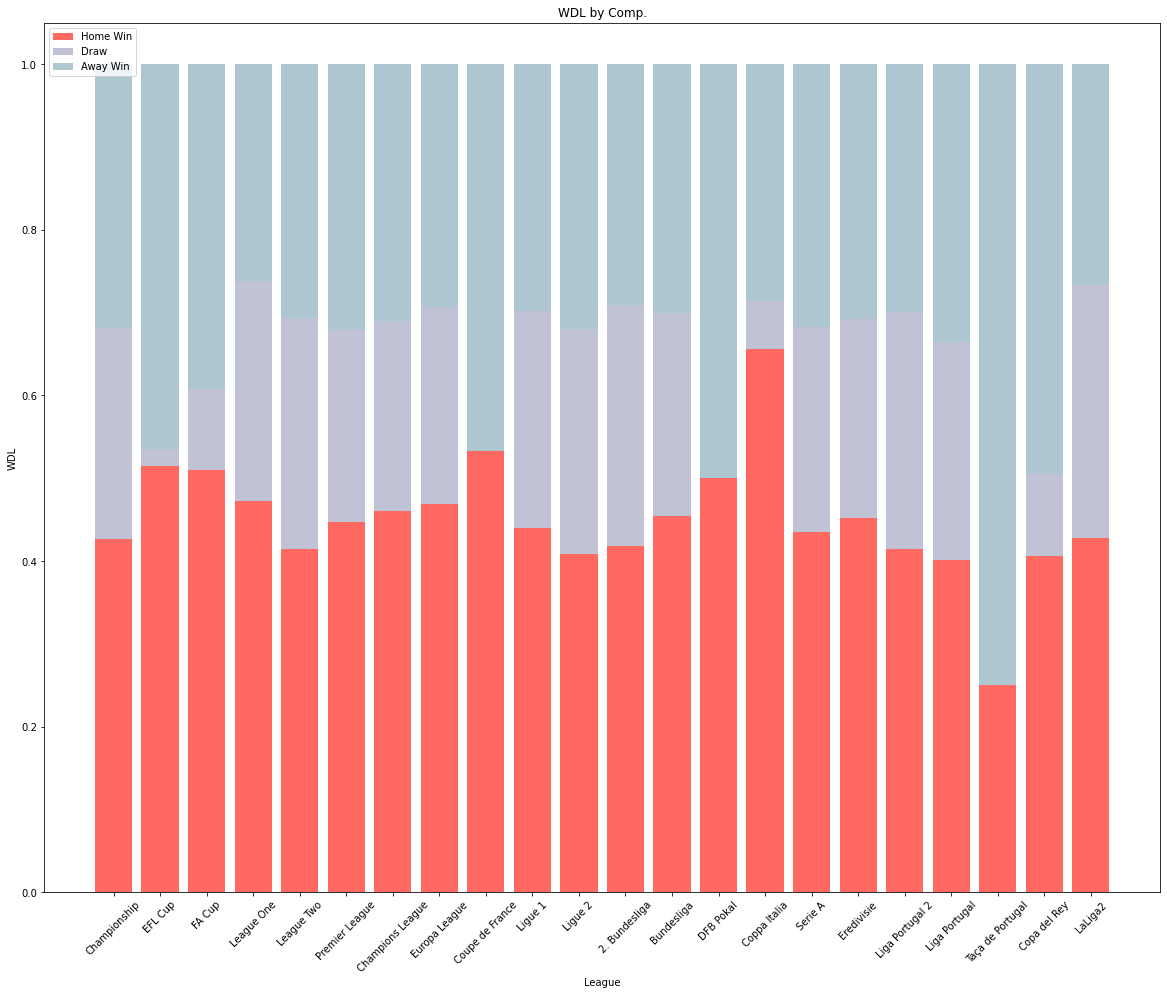

In [25]:
success_rates = []
for cat_value in df[cat_col].unique():
    home_win_group = df['home_win'][df[cat_col] == cat_value]
    draw_group = df['draw'][df[cat_col] == cat_value]
    away_win_group = df['away_win'][df[cat_col] == cat_value]
    
    # Compute the success rate for each group
    home_win_rate = home_win_group.mean()
    draw_rate = draw_group.mean()
    away_win_rate = away_win_group.mean()
    
    success_rates.append((home_win_rate, draw_rate, away_win_rate))
    
    
# Create a bar plot of the success rates
fig, ax = plt.subplots(figsize=(20, 16))
colors = ['#ff6961', '#c2c2d6', '#aec6cf']
labels = ['Home Win', 'Draw', 'Away Win']

for i, (home_win_rate, draw_rate, away_win_rate) in enumerate(success_rates):
    total_rate = home_win_rate + draw_rate + away_win_rate
    home_win_length = home_win_rate / total_rate
    draw_length = draw_rate / total_rate
    away_win_length = away_win_rate / total_rate
    ax.bar(i, home_win_length, color=colors[0])
    ax.bar(i, draw_length, bottom=home_win_length, color=colors[1])
    ax.bar(i, away_win_length, bottom=home_win_length + draw_length, color=colors[2])

ax.set_xlabel(cat_col)
ax.set_ylabel('WDL')
ax.set_title('WDL by Comp.')
ax.set_xticks(range(len(df[cat_col].unique())))
ax.set_xticklabels(df[cat_col].unique(), rotation=45)
ax.legend(labels, loc='upper left')
plt.show()

In [26]:
cat_col = "League"
same_var = []
print("Levene's Test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['home_win'][df[cat_col] == cat_value]
    group2 = df['home_win'][df[cat_col] != cat_value]

    # Perform a t-test on the means
    _, p = stats.levene(group1, group2)
    if p > 0.05:
        same_var.append(cat_value)
    
    print(f"{cat_value} vs others: p = {p:.4f}")

print("T-test:")
for cat_value in df[cat_col].unique():
    
    group1 = df['home_win'][df[cat_col] == cat_value]
    group2 = df['home_win'][df[cat_col] != cat_value]
    
    # Compute the success rate for each group
    rate1 = group1.mean()
    rate2 = group2.mean()
    
    
    if not cat_value in same_var:
        _, p = stats.ttest_ind(group1, group2, equal_var=False)
    else:
        _, p = stats.ttest_ind(group1, group2, equal_var=True)
    
    print(f"{cat_value} vs others: Home Win Rate = {rate1:.4f} vs {rate2:.4f}, p = {p:.4f}")

Levene's Test:
Championship vs others: p = 0.2104
EFL Cup vs others: p = 0.1091
FA Cup vs others: p = 0.1110
League One vs others: p = 0.2526
League Two vs others: p = 0.1211
Premier League vs others: p = 0.4791
Champions League vs others: p = 0.1842
Europa League vs others: p = 0.1495
Coupe de France vs others: p = 0.5671
Ligue 1 vs others: p = 0.8351
Ligue 2 vs others: p = 0.3517
2. Bundesliga vs others: p = 0.0212
Bundesliga vs others: p = 0.2057
DFB Pokal vs others: p = 0.7078
Coppa Italia vs others: p = 0.0174
Serie A vs others: p = 0.4934
Eredivisie vs others: p = 0.5942
Liga Portugal 2 vs others: p = 0.1788
Liga Portugal vs others: p = 0.0280
Taça de Portugal vs others: p = 0.4413
Copa del Rey vs others: p = 0.4468
LaLiga2 vs others: p = 0.3857
T-test:
Championship vs others: Home Win Rate = 0.4260 vs 0.4424, p = 0.2104
EFL Cup vs others: Home Win Rate = 0.5145 vs 0.4401, p = 0.0087
FA Cup vs others: Home Win Rate = 0.5098 vs 0.4403, p = 0.0264
League One vs others: Home Win Rat

It appears as though using embeddings for both country and league variables may be more useful for predicting total goals scored rather than the outcome of the match. But it is something we can and will experiment with when we are looking to improve our baseline model for match prediction later on. Given the amount of unique team names in the dataset, it is infeasible to generate embeddings for these variables. We will look at the dates in the Kickoff column to see if this may have any predictive power.

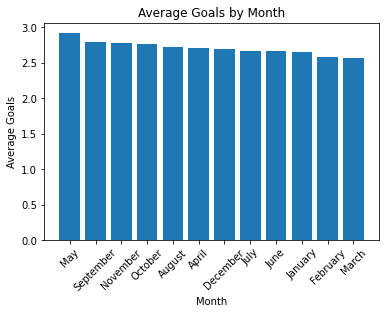

In [27]:
df1 = df.copy()
df1 = df1.reset_index(drop = True)

df1['Kickoff'] = df1['Kickoff'].str.replace(".", "/", regex=True)
df1['Kickoff'] = df1['Kickoff'].str.replace("-", "/", regex=True)

df1['Kickoff'] = pd.to_datetime(df1['Kickoff'], format='%d/%m/%Y %H:%M')

# Group the data by the month and compute the average goals scored
df_month = df1.groupby(df1['Kickoff'].dt.strftime('%B'))['Total Goals'].mean()

# # Sort the data by average goals scored in descending order
df_month = df_month.sort_values(ascending=False)

# Create a bar plot of the average goals scored by month
fig, ax = plt.subplots()
ax.bar(df_month.index, df_month)
ax.set_xlabel('Month')
ax.set_ylabel('Average Goals')
ax.set_title('Average Goals by Month')
plt.xticks(rotation=45)
plt.show()

We can tell from this chart that the beginning and end of seasons tend to have more goals scored than those winter months in the middle of the season. 

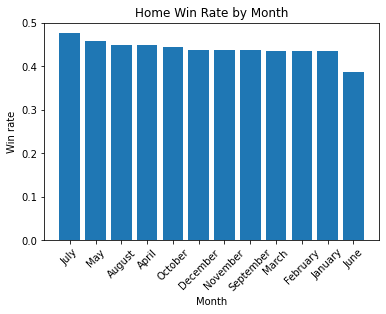

In [30]:
df1 = df.copy()
df1 = df1.reset_index(drop = True)

df1['Kickoff'] = df1['Kickoff'].str.replace(".", "/", regex=True)
df1['Kickoff'] = df1['Kickoff'].str.replace("-", "/", regex=True)

df1['Kickoff'] = pd.to_datetime(df1['Kickoff'], format='%d/%m/%Y %H:%M')

df_month = df1.groupby(df1['Kickoff'].dt.strftime('%B'))['home_win'].mean()

df_month = df_month.sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(df_month.index, df_month)
ax.set_xlabel('Month')
ax.set_ylabel('Win rate')
ax.set_title('Home Win Rate by Month')
plt.xticks(rotation=45)
plt.show()

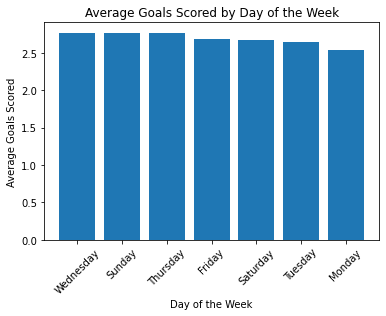

In [31]:
df1 = df.copy()
df1 = df1.reset_index(drop = True)

df1['Kickoff'] = df1['Kickoff'].str.replace(".", "/", regex=True)
df1['Kickoff'] = df1['Kickoff'].str.replace("-", "/", regex=True)
df1['Kickoff'] = pd.to_datetime(df1['Kickoff'], format='%d/%m/%Y %H:%M')

df1['DayOfWeek'] = df1['Kickoff'].dt.day_name()

df_weekday = df1.groupby('DayOfWeek')['Total Goals'].mean()
df_weekday = df_weekday.sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(df_weekday.index, df_weekday.values)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Average Goals Scored')
ax.set_title('Average Goals Scored by Day of the Week')
plt.xticks(rotation=45)
plt.show()

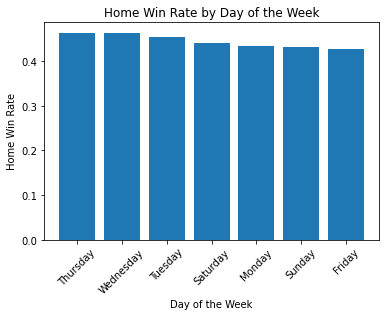

In [33]:
df1 = df.copy()
df1 = df1.reset_index(drop = True)

df1['Kickoff'] = df1['Kickoff'].str.replace(".", "/", regex=True)
df1['Kickoff'] = df1['Kickoff'].str.replace("-", "/", regex=True)
df1['Kickoff'] = pd.to_datetime(df1['Kickoff'], format='%d/%m/%Y %H:%M')

df1['DayOfWeek'] = df1['Kickoff'].dt.day_name()

df_weekday = df1.groupby('DayOfWeek')['home_win'].mean()

df_weekday = df_weekday.sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(df_weekday.index, df_weekday.values)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Home Win Rate')
ax.set_title('Home Win Rate by Day of the Week')
plt.xticks(rotation=45)
plt.show()

The month of year and day of the week might be useful variables in predicting match outcome and total goals. For now though, we will build a basic model to use as a baseline. The following EDA will focus on what preprocessing needs to be done for that model. We take a look at the distribution of some of our predictor variables. It is likely that we will see some positive skew in some of our variables. If so we can scale our variables and then apply a box-cox transformation to normalise the distribution of the data.

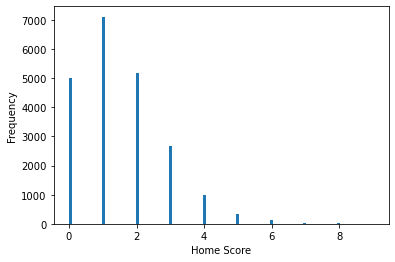

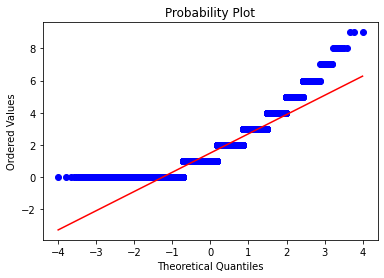

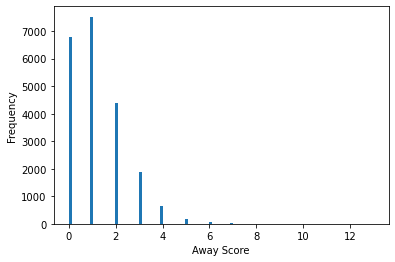

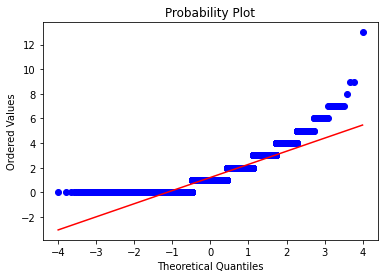

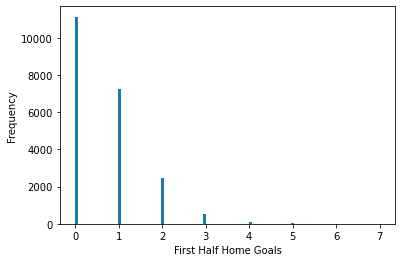

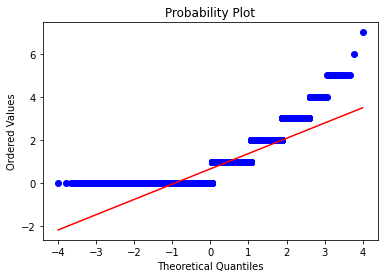

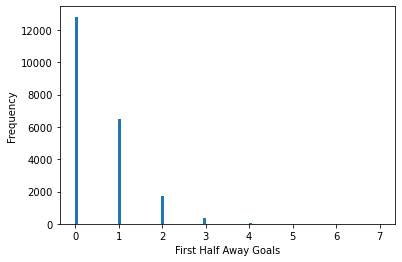

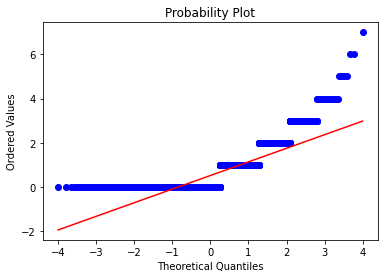

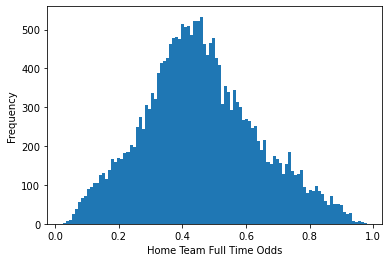

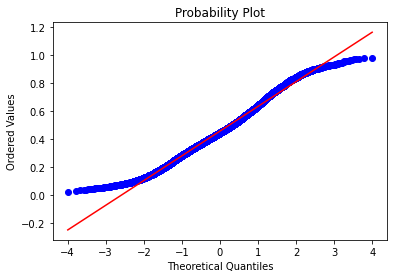

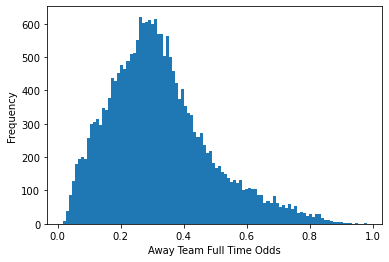

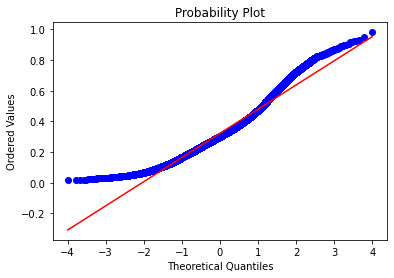

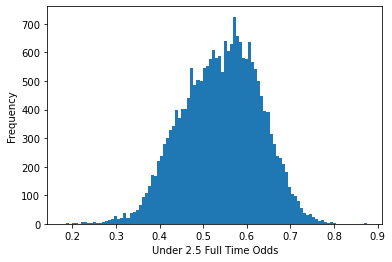

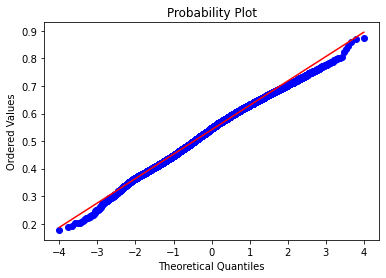

In [34]:
discrete_vars_strings = ["Game Win", "Game Loss", "Game Score", "Game Concede", 
                         "home_win", "draw", "away_win", "fhg", "bts", "BTS", "Draw", "Away Win", "Home Win"
                         'o25', 'home_goal', 'away_goal', "Over 1.5", "Over 2.5", "Total Goals", "Bucket"]

for col in df.columns[:50]:
    if any(var_string in col for var_string in discrete_vars_strings):
        continue
    else:
        x = df[col]
        # Create a histogram of the predictor variable
        plt.hist(x, bins=100)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

        # Create a Q-Q plot of the predictor variable
        stats.probplot(x, dist="norm", plot=plt)
        plt.xlabel('Theoretical Quantiles')
        plt.ylabel('Ordered Values')
        plt.show()

In [35]:
df_original = df.copy()

In [36]:
# get columns to normalise

to_scale = ['Home Team Scored Last 3',
 'Home Team Scored Last 5',
 'Home Team Scored Last 8',
 'Home Team Conceded Last 3',
 'Home Team Conceded Last 5',
 'Home Team Conceded Last 8',
 'Away Team Scored Last 3',
 'Away Team Scored Last 5',
 'Away Team Scored Last 8',
 'Away Team Conceded Last 3',
 'Away Team Conceded Last 5',
 'Away Team Conceded Last 8',
 'Home Team Scored 1st Half Last 3',
 'Home Team Scored 1st Half Last 5',
 'Home Team Scored 1st Half Last 8',
 'Home Team Conceded 1st Half Last 3',
 'Home Team Conceded 1st Half Last 5',
 'Home Team Conceded 1st Half Last 8',
 'Away Team Scored 1st Half Last 3',
 'Away Team Scored 1st Half Last 5',
 'Away Team Scored 1st Half Last 8',
 'Away Team Conceded 1st Half Last 3',
 'Away Team Conceded 1st Half Last 5',
 'Away Team Conceded 1st Half Last 8',
 'Home Team Scored 2nd Half Last 3',
 'Home Team Scored 2nd Half Last 5',
 'Home Team Scored 2nd Half Last 8',
 'Home Team Conceded 2nd Half Last 3',
 'Home Team Conceded 2nd Half Last 5',
 'Home Team Conceded 2nd Half Last 8',
 'Away Team Scored 2nd Half Last 3',
 'Away Team Scored 2nd Half Last 5',
 'Away Team Scored 2nd Half Last 8',
 'Away Team Conceded 2nd Half Last 3',
 'Away Team Conceded 2nd Half Last 5',
 'Away Team Conceded 2nd Half Last 8',
 'Home Team Shots Target 3',
 'Home Team Shots Target 5',
 'Home Team Shots Target 8',
 'Home Team Shots Target Conceded 3',
 'Home Team Shots Target Conceded 5',
 'Home Team Shots Target Conceded 8',
 'Away Team Shots Target  3',
 'Away Team Shots Target 5',
 'Away Team Shots Target 8',
 'Away Team Shots Target Conceded 3',
 'Away Team Shots Target Conceded 5',
 'Away Team Shots Target Conceded 8',
 'Home Team Shots Target 1st Half 3',
 'Home Team Shots Target 1st Half 5',
 'Home Team Shots Target 1st Half 8',
 'Home Team Shots Target Conceded 1st Half 3',
 'Home Team Shots Target Conceded 1st Half 5',
 'Home Team Shots Target Conceded 1st Half 8',
 'Home Team Shots Target 2nd Half 3',
 'Home Team Shots Target 2nd Half 5',
 'Home Team Shots Target 2nd Half 8',
 'Home Team Shots Target Conceded 2nd Half 3',
 'Home Team Shots Target Conceded 2nd Half 5',
 'Home Team Shots Target Conceded 2nd Half 8',
 'Away Team Shots Target 1st Half 3',
 'Away Team Shots Target 1st Half 5',
 'Away Team Shots Target 1st Half 8',
 'Away Team Shots Target Conceded 1st Half 3',
 'Away Team Shots Target Conceded 1st Half 5',
 'Away Team Shots Target Conceded 1st Half 8',
 'Away Team Shots Target 2nd Half 3',
 'Away Team Shots Target 2nd Half 5',
 'Away Team Shots Target 2nd Half 8',
 'Away Team Shots Target Conceded 2nd Half 3',
 'Away Team Shots Target Conceded 2nd Half 5',
 'Away Team Shots Target Conceded 2nd Half 8',
 'Home Team Shots 3',
 'Home Team Shots 5',
 'Home Team Shots 8',
 'Home Team Shots Conceded 3',
 'Home Team Shots Conceded Last 5',
 'Home Team Shots Conceded 8',
 'Away Team Shots 3',
 'Away Team Shots 5',
 'Away Team Shots 8',
 'Away Team Shots Conceded 3',
 'Away Team Shots Conceded Last 5',
 'Home Team Corner Average For 3',
 'Home Team Corner Average For 5',
 'Home Team Corner Average For 8',
 'Home Team Corner Average Against 3',
 'Home Team Corner Average Against 5',
 'Home Team Corner Average Against 8',
 'Home Team Corner Average For 1st Half 3',
 'Home Team Corner Average For 1st Half 5',
 'Home Team Corner Average For 1st Half 8',
 'Home Team Corner Average Against 1st Half 3',
 'Home Team Corner Average Against 1st Half 5',
 'Home Team Corner Average Against 1st Half 8',
 'Home Team Corner Average For 2nd Half 3',
 'Home Team Corner Average For 2nd Half 5',
 'Home Team Corner Average For 2nd Half 8',
 'Home Team Corner Average Against 2nd Half 3',
 'Home Team Corner Average Against 2nd Half 5',
 'Home Team Corner Average Against 2nd Half 8',
 'Away Team Corner Average For 3',
 'Away Team Corner Average For 5',
 'Away Team Corner Average For 8',
 'Away Team Corner Average Against 3',
 'Away Team Corner Average Against 5',
 'Away Team Corner Average Against 8',
 'Away Team Corner Average For 1st Half 3',
 'Away Team Corner Average For 1st Half 5',
 'Away Team Corner Average For 1st Half 8',
 'Away Team Corner Average Against 1st Half 3',
 'Away Team Corner Average Against 1st Half 5',
 'Away Team Corner Average Against 1st Half 8',
 'Away Team Corner Average For 2nd Half 3',
 'Away Team Corner Average For 2nd Half 5',
 'Away Team Corner Average For 2nd Half 8',
 'Away Team Corner Average Against 2nd Half 3',
 'Away Team Corner Average Against 2nd Half 5',
 'Away Team Corner Average Against 2nd Half 8']

to_normalise = []
normalised_cols = df[to_scale]

scaler = MinMaxScaler()
scaler.fit(normalised_cols)
df_scaled = pd.DataFrame(scaler.transform(normalised_cols), columns=normalised_cols.columns)
df_normalised = df_scaled.copy()

for column in df_normalised.columns:
    df_normalised[column], _ = boxcox(df_normalised[column] + 0.01)

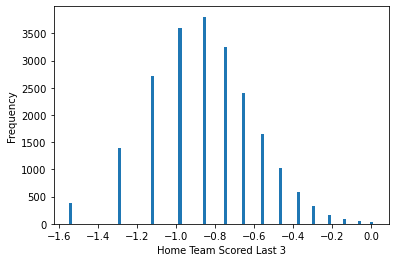

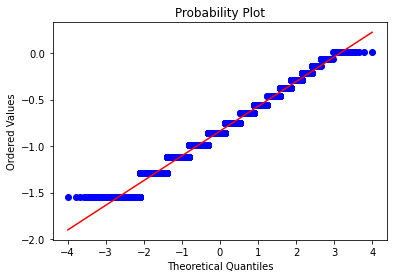

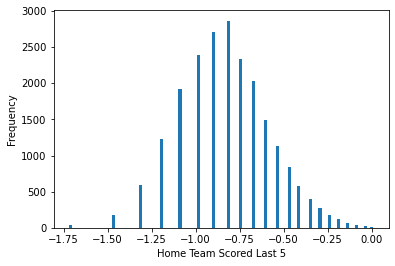

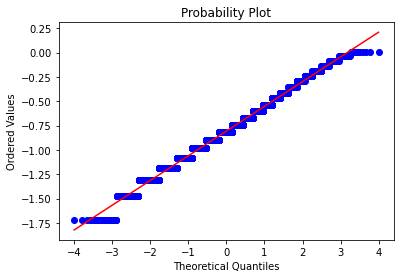

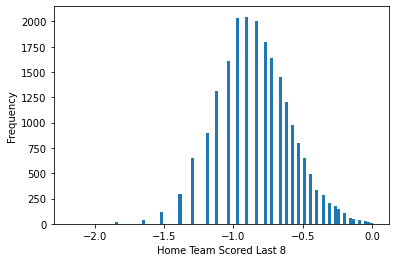

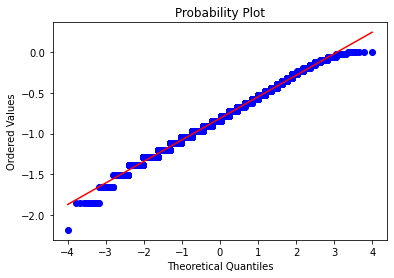

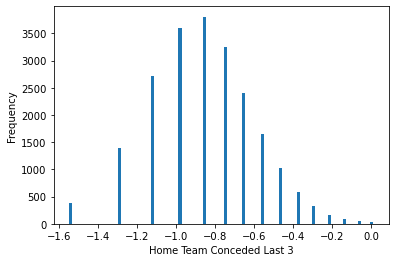

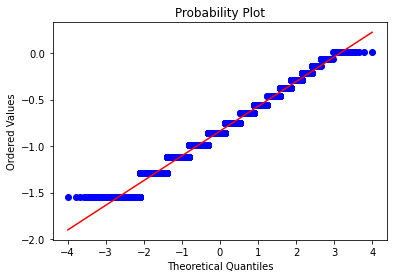

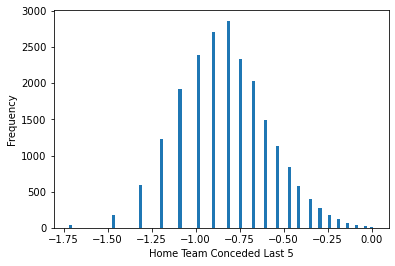

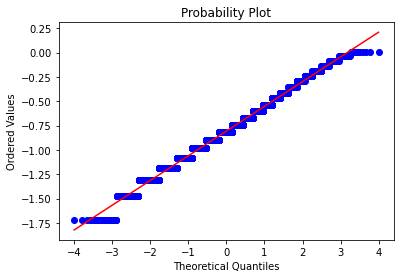

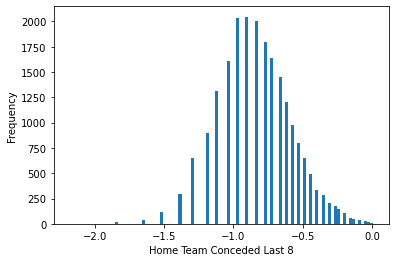

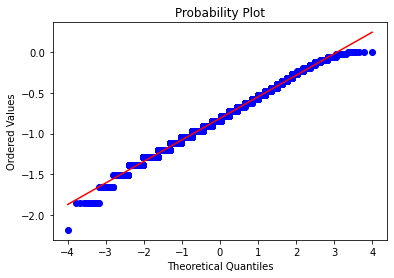

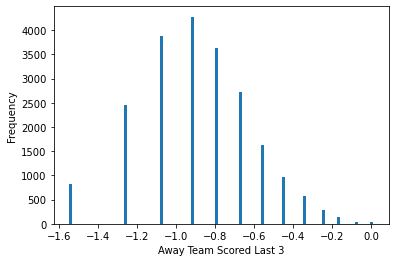

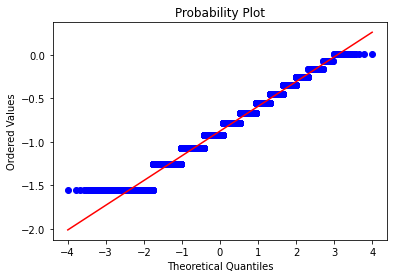

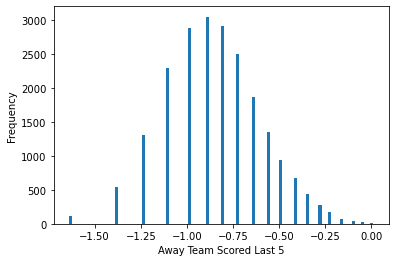

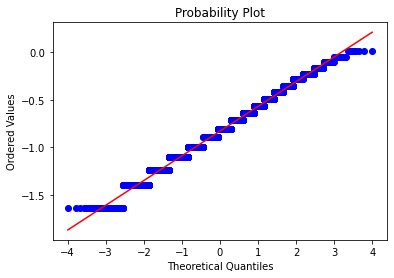

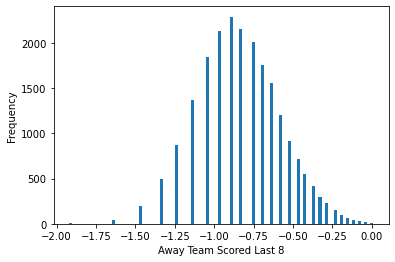

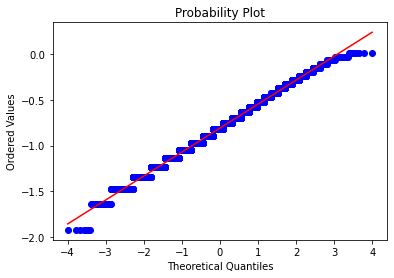

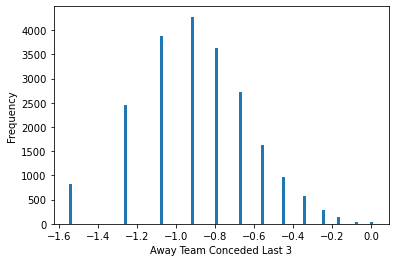

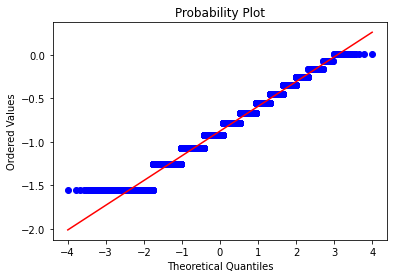

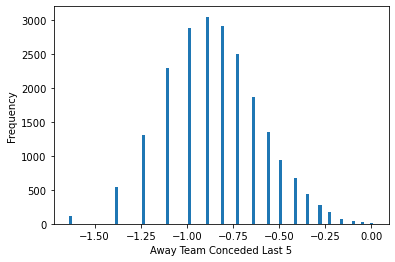

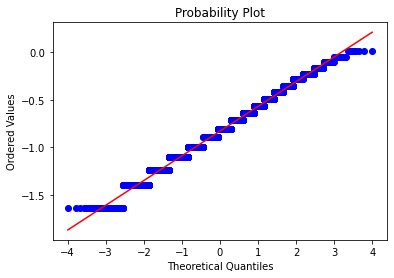

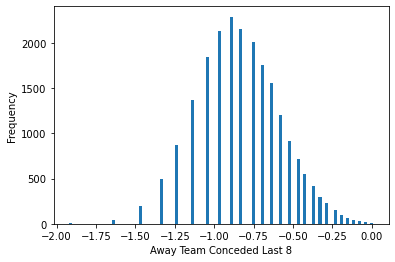

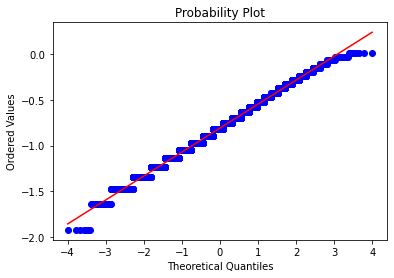

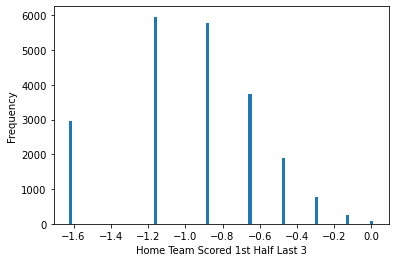

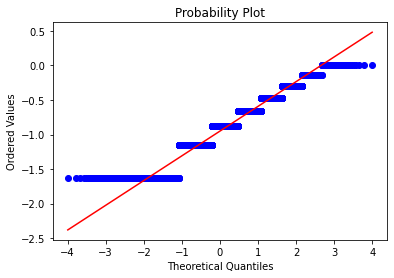

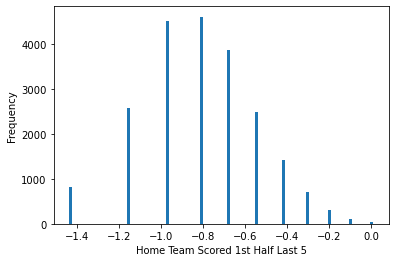

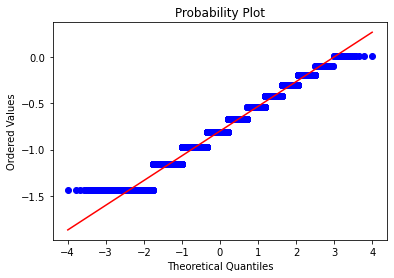

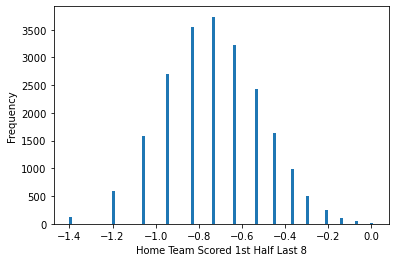

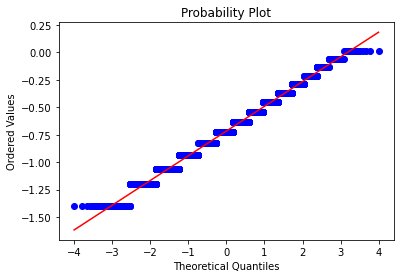

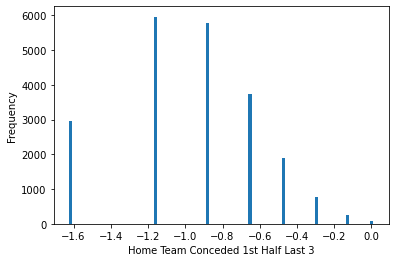

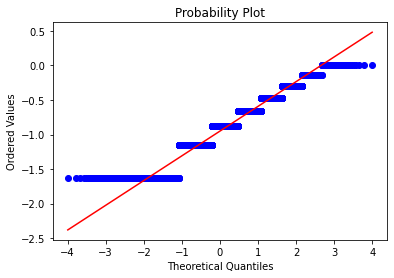

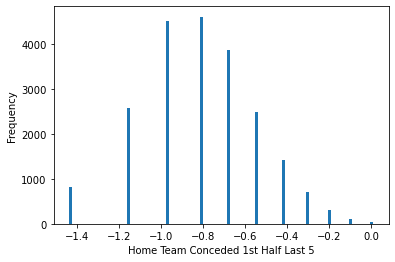

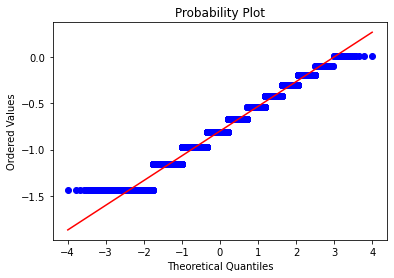

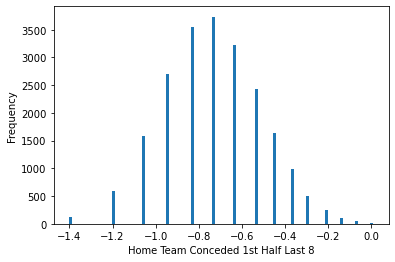

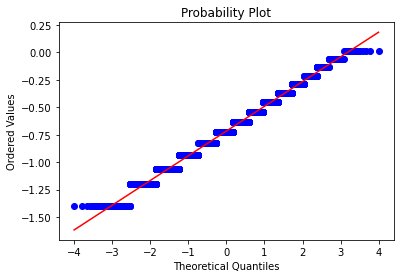

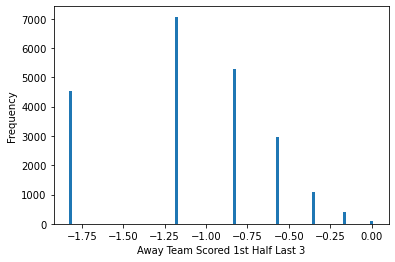

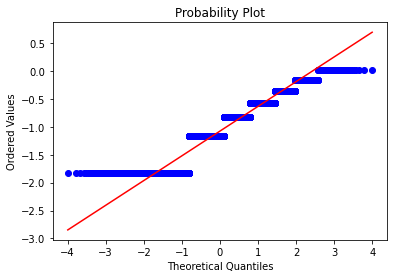

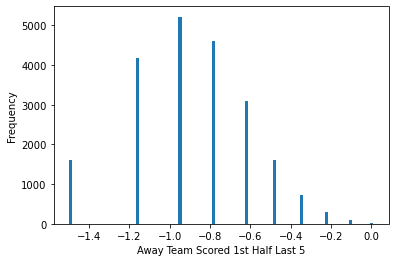

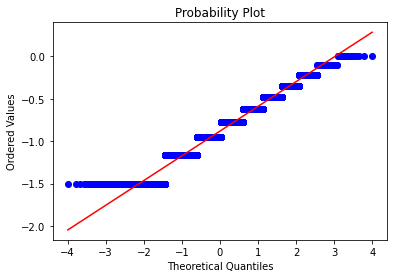

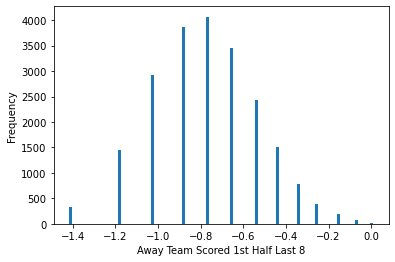

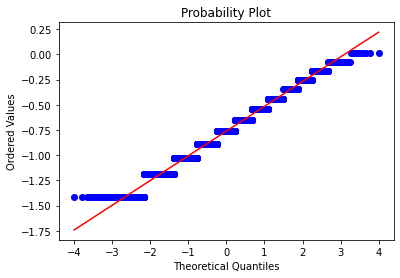

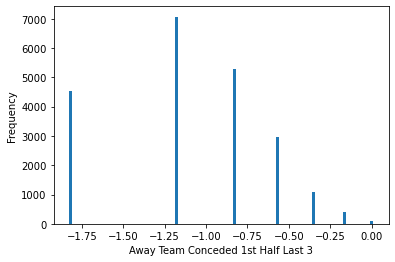

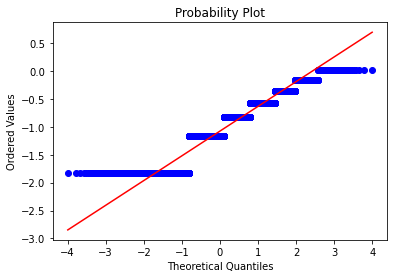

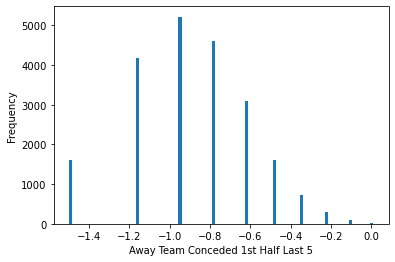

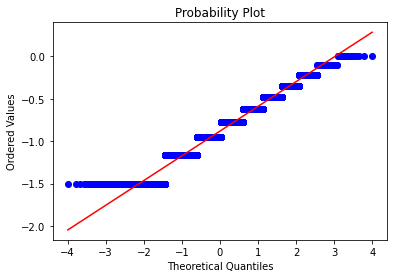

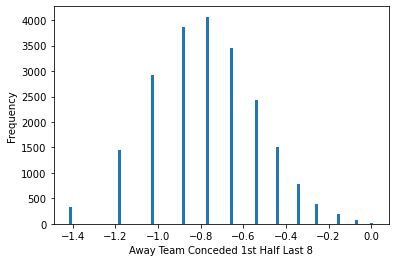

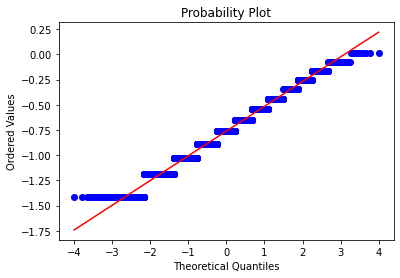

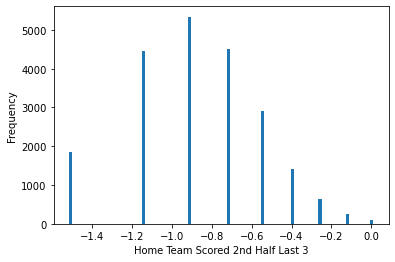

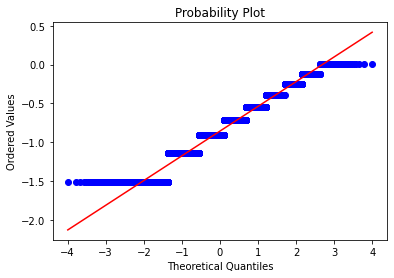

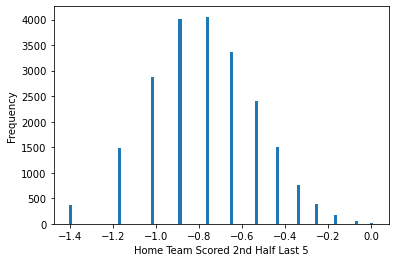

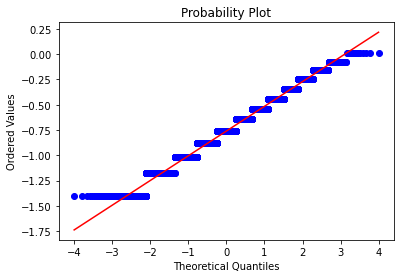

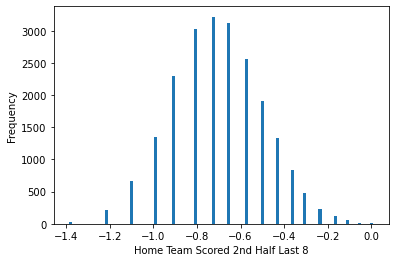

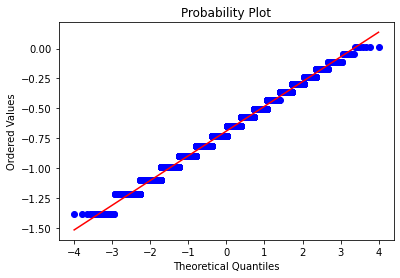

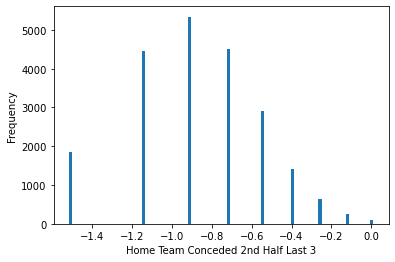

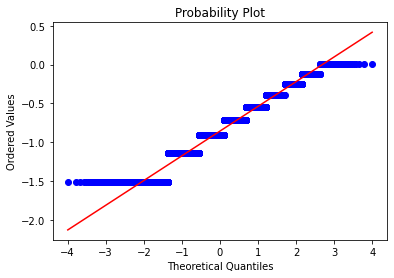

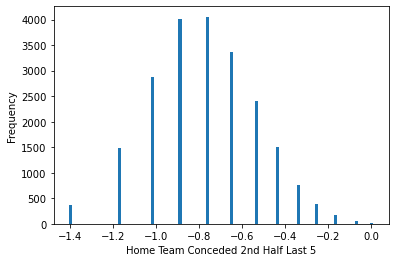

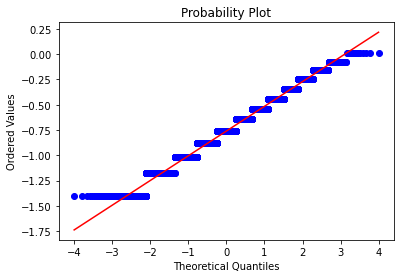

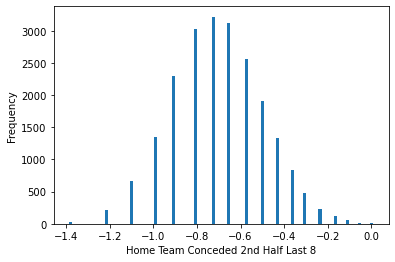

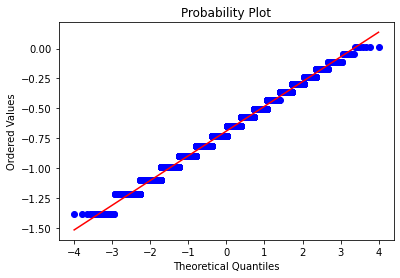

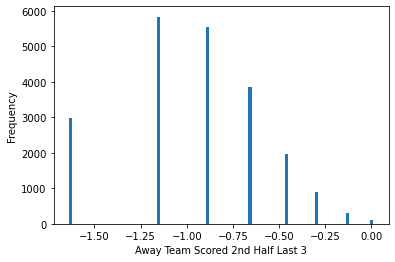

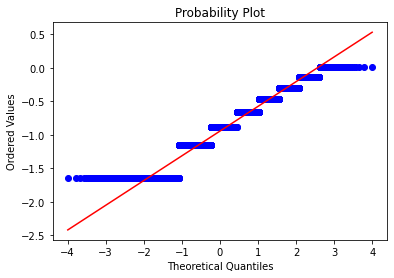

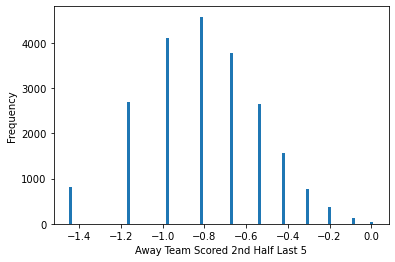

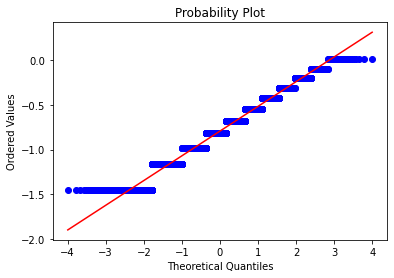

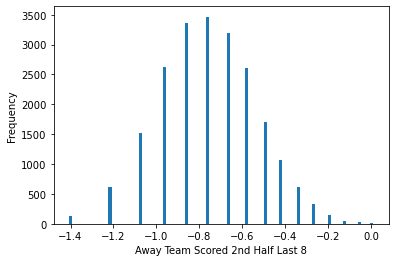

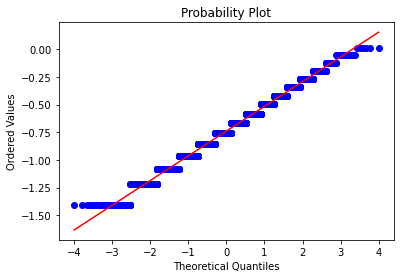

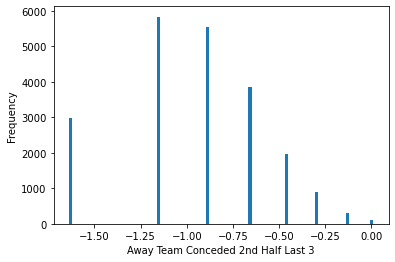

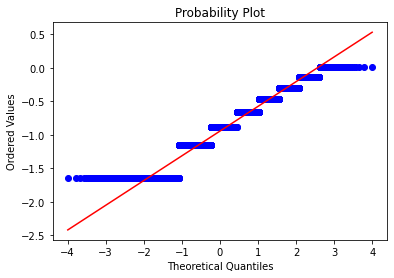

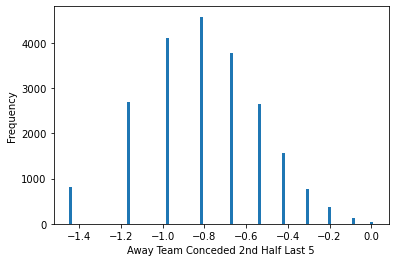

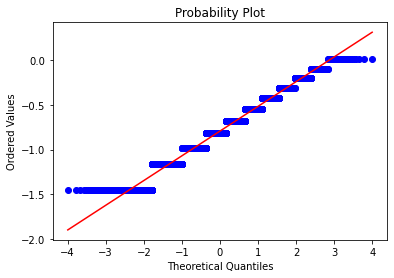

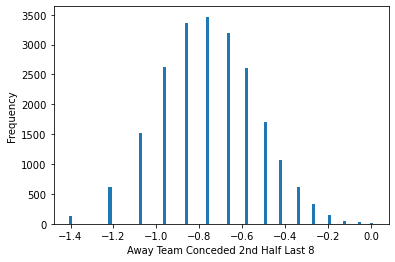

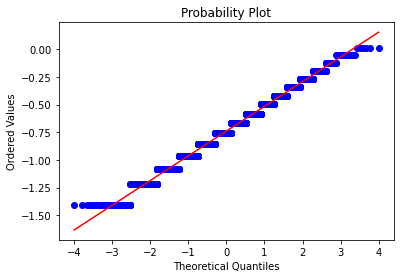

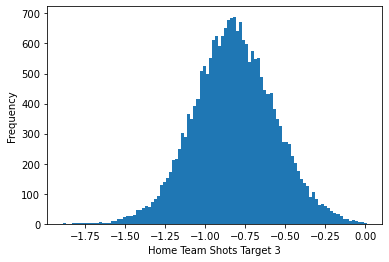

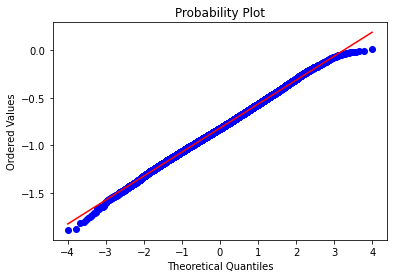

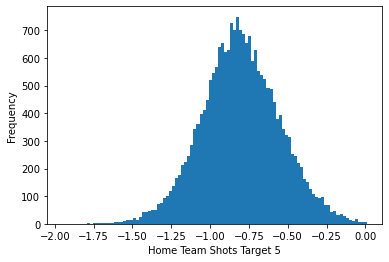

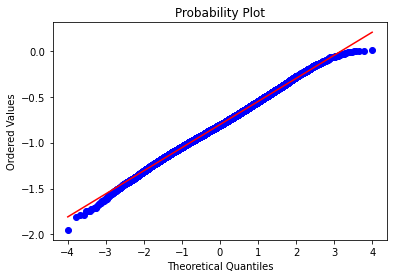

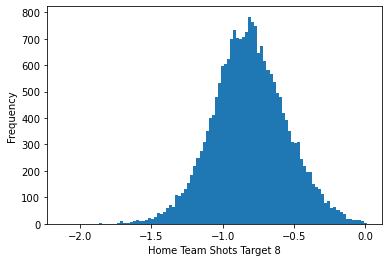

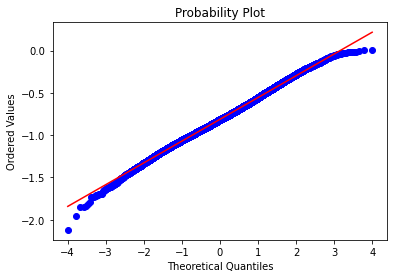

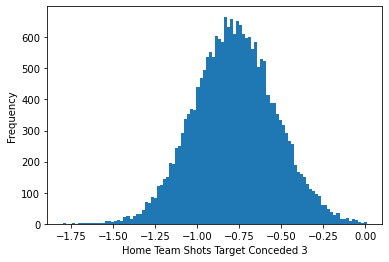

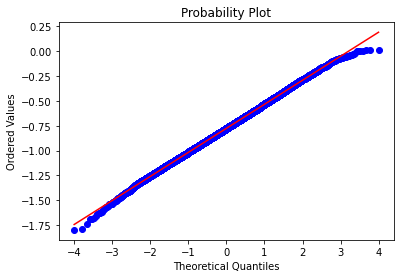

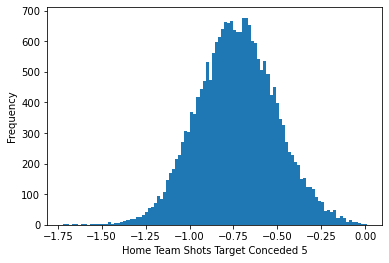

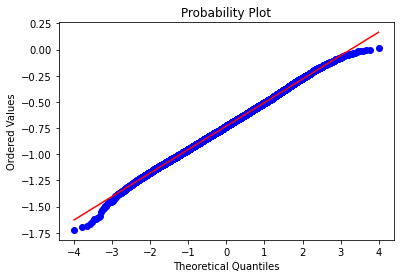

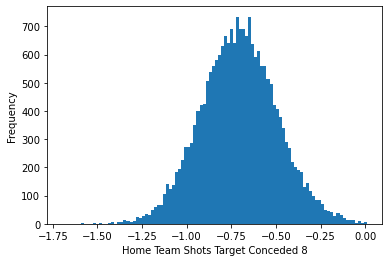

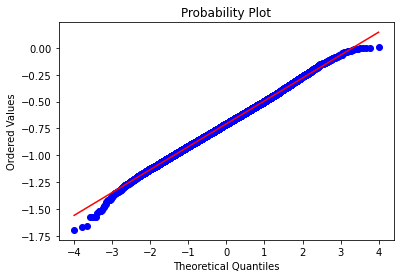

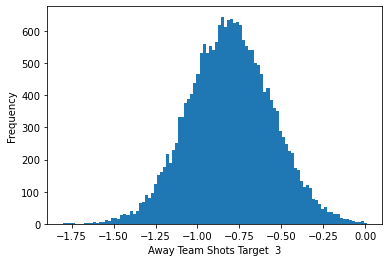

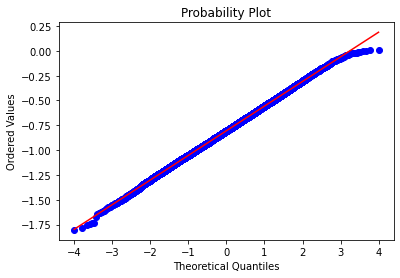

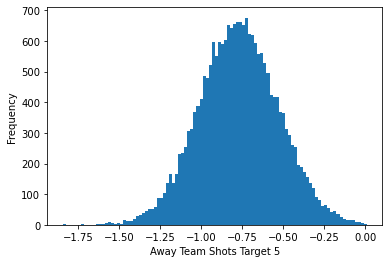

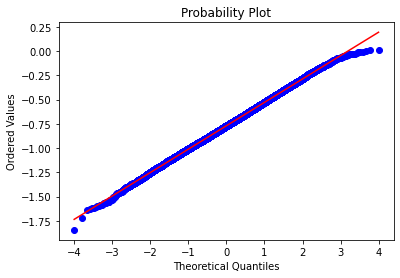

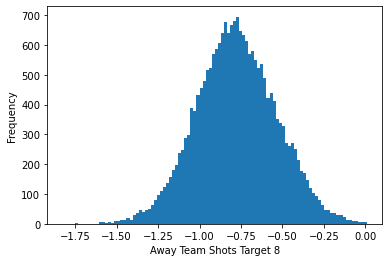

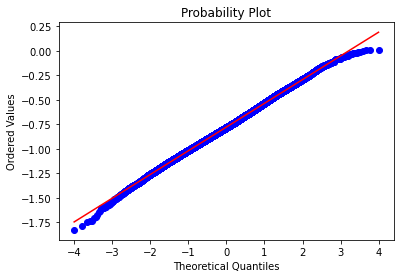

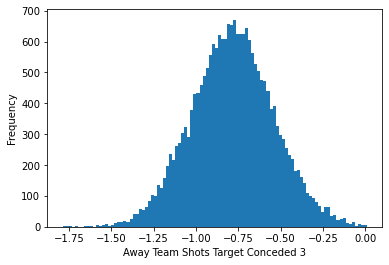

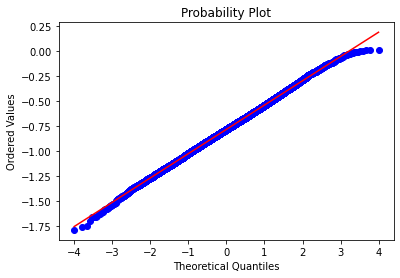

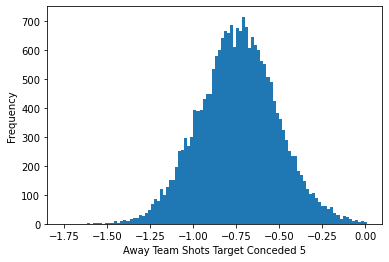

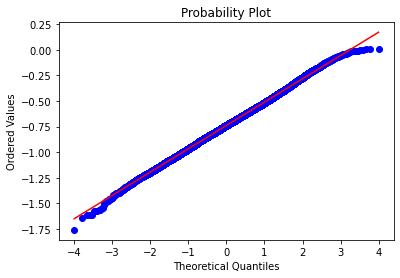

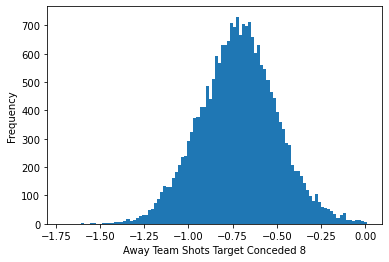

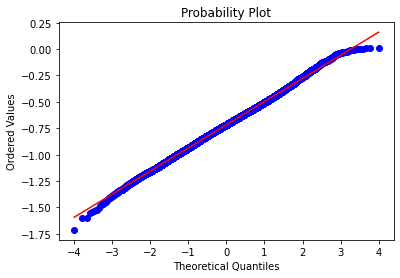

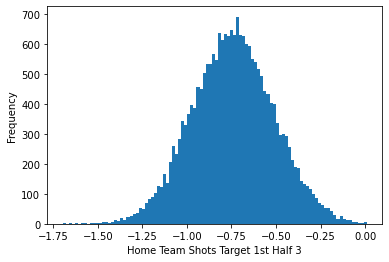

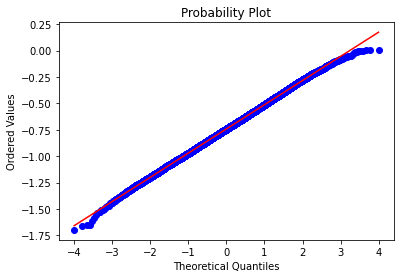

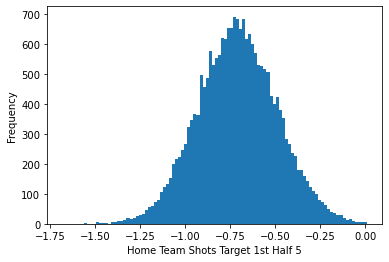

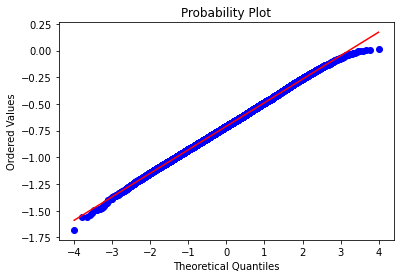

In [37]:
for col in df_normalised.columns[0:50]:
    
    x = df_normalised[col]
    # Create a histogram of the predictor variable
    plt.hist(x, bins=100)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    # Create a Q-Q plot of the predictor variable
    stats.probplot(x, dist="norm", plot=plt)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.show()

We have scaled and normalised our predictor variables. Given that our data have several moving average columns calculated over periods of 3, 5, and 8 windows, it is highly likely that we have multicollinearity. This can hinder any models ability to uncover relationships in our data. Highly correlated variables increase nose but do not add significant information. As a result our final model's accuracy may be short of what it could be. If we do see significant multicollinearity, we can remove variables. We can also choose a model that is equipped to deal with multicollinearity such as ridge regression, lasso regression, or a tree-based algorithm.

In [38]:
corr_matrix = df.corr()
corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
corr_pairs = corr_pairs[corr_pairs != 1.0] 
print(corr_pairs[:50])

home_win_prob                                Home Team Full Time Odds                       0.999868
away_win_prob                                Away Team Full Time Odds                       0.999840
o25_prob                                     Over 2.5 Full Time Odds                        0.999490
bts_prob                                     BTS Yes Full Time Odds                         0.998973
draw_prob                                    Draw Full Time Odds                            0.998418
Away Team Possession For 1st Half 8          Away Team Possession For 1st Half 5            0.984678
Away Team Possession For 8                   Away Team Possession For 5                     0.984565
Home Team Possession For 1st Half 8          Home Team Possession For 1st Half 5            0.983375
Home Team Possession For 8                   Home Team Possession For 5                     0.983291
Away Team Possession For 2nd Half 5          Away Team Possession For 2nd Half 8           

In [39]:
target_var = 'home_win'

targets = ['draw', 'away_win', 'fhg', 'home_goal', 'away_goal', "Total Goals", "Over 2.5",
           "away_win_prob",'home_win_prob', "Home Score", "Away Score", "Draw",
           "fhg", "First Half Home Goals", "First Half Away Goals", "Bucket"]

df1 = df.drop(targets, axis = 1)

corr_matrix = df1.corr()[[target_var]]
corr_matrix_sorted = corr_matrix.iloc[:-1].abs().sort_values(target_var, ascending=False)
corr_pairs = corr_matrix_sorted[corr_matrix_sorted.index.map(lambda x: x[0]!=x[1])]
corr_pairs = corr_pairs[corr_pairs != 1.0] 

print("Highest absolute correlations with Home Win: \n \n ",corr_pairs[1:20])


Highest absolute correlations with Home Win: 
 
                                       home_win
Home Team Full Time Odds             0.355918
Away Team Full Time Odds             0.340591
Home Team Possession For 8           0.177519
Home Team Possession For 1st Half 8  0.176517
draw_prob                            0.169627
Draw Full Time Odds                  0.169458
Home Team Shots Target 8             0.167221
Home Team Shots 8                    0.166342
Home Team Possession For 5           0.165090
Home Team Possession For 1st Half 5  0.165056
Home Team Conceded Last 8            0.164853
Home Team Scored Last 8              0.164853
Home Team Possession For 2nd Half 8  0.156911
Home Team Shots Target 1st Half 8    0.156228
Home Team Shots Target 5             0.153257
Home Team Shots 5                    0.152736
Home Team Possession For 1st Half 3  0.149147
Home Team Possession For 3           0.148092
Away Team Possession For 8           0.147059


We have a high degree of multicollinearity. Before removing the highly correlated variables, we will train an xgboost classifier. This is a gradient boosted tree based algorithm, and it is typically robust to multicollinearity. We can then test the difference removing the correlated variables makes.

To analyse the performance of the model, we use the AUC metric. We also construct some functions below to test the efficacy of betting strategy using the model. The first is a simple strategy where we bet on any home win where the prediction meets a given threshold. The second look for disparity between our models predictions and the bookies odds, and backs or lays accordingly. The results given by the laying strategy will be somewhat inaccurate as we are using (1 - odds) instead of using the true price for a non-Home win, but it should give a (slightly exagerrated) estimate of what the true returns would be.

We remove the any target/unnecessary variables and ensure even sampling between target classes with the resample method from sklearn.utils

In [40]:
def get_profits(odds, preds, threshold, validation_set):

    profit = 0
    bets = 0
    odds = odds.reset_index(drop = True)

    for i in range(len(odds)):

        if preds[i] > threshold:
            bets += 1
            p = odds[i]
            o = 1/(p)
            bet = 1 * o 
            if validation_set[i] == 1:
                profit += (bet - 1)
            else:
                profit += -1
    return profit, bets, profit/bets*100

def get_value_strat1(odds, preds, threshold, validation_set):
    
    c1 = 0
    c2 = 0
    p1 = 0
    odds = odds.reset_index(drop = True)
    
    for i in range(len(preds)):
        if preds[i] > odds[i]:
            if abs(preds[i] - odds[i]) > threshold:
                if validation_set[i] == 1:
                    p = odds[i]
                    o = 1/(p)
                    p1 += (1 * o) - 1
                    c1 += 1
                else:
                    p1 += -1
                    c2 += 1
                    
                    
    return p1, c1, c2, (p1/(c1+c2))*100

def get_value_strat2(odds, preds, threshold, validation_set):
    
    c1 = 0
    c2 = 0
    p1 = 0
    odds = odds.reset_index(drop = True)
    
    for i in range(len(preds)):
        if preds[i] < odds[i]:
            if abs(preds[i] - odds[i]) > threshold:
                if validation_set[i] == 0:
                    p = 1 - odds[i]
                    o = 1/(p)
                    p1 += (1 * o) - 1
                    c1 += 1
                else:
                    p1 += -1
                    c2 += 1
                    
                    
    return p1, c1, c2, (p1/(c1+c2))*100

In [69]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.utils import resample

targets = ['home_win', 'draw', 'away_win', 'fhg', 'home_goal', 'away_goal', 'Country', 'League', 'Kickoff',
           "Home Score", "Away Score", 'Over 2.5','Over 1.5','BTS','Draw', 
           "fhg", "First Half Home Goals", "First Half Away Goals", "Bucket", 
           'Total Goals', "Home Team Full Time Odds", "Draw Full Time Odds", "Away Team Full Time Odds"]

cols = df_normalised.columns
df[cols] = df_normalised[cols]

y = df['home_win']
X = df.drop(targets, axis=1)

# Upsample minority class
X_minority = X[y == 1]
y_minority = y[y == 1]
X_majority = X[y == 0]
y_majority = y[y == 0]
X_upsampled, y_upsampled = resample(X_minority, y_minority, replace=True, n_samples=X_majority.shape[0], random_state=42)

# Combine majority class with upsampled minority class
X_resampled = pd.concat([X_majority, X_upsampled])
y_resampled = pd.concat([y_majority, y_upsampled])

X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [70]:
# print the columns of X to ensure there is no data leakage

list(X.columns)

['Over 2.5 Full Time Odds',
 'Under 2.5 Full Time Odds',
 'BTS Yes Full Time Odds',
 'BTS No Full Time Odds',
 'Last Home Game Win',
 '2nd Last Home Game Win',
 '3rd Last Home Game Win',
 '4th Last Home Game Win',
 '5th Last Home Game Win',
 'Last Home Game Loss',
 '2nd Last Home Game Loss',
 '3rd Last Home Game Loss',
 '4th Last Home Game Loss',
 '5th Last Home Game Loss',
 'Last Away Game Win',
 '2nd Last Away Game Win',
 '3rd Last Away Game Win',
 '4th Last Away Game Win',
 '5th Last Away Game Win',
 'Last Away Game Loss',
 '2nd Last Away Game Loss',
 '3rd Last Away Game Loss',
 '4th Last Away Game Loss',
 '5th Last Away Game Loss',
 'Last Home Game Score 0',
 '2nd Last Home Game Score 0',
 '3rd Last Home Game Score 0',
 '4th Last Home Game Score 0',
 '5th Last Home Game Score 0',
 'Last Home Game Score 1',
 '2nd Last Home Game Score 1',
 '3rd Last Home Game Score 1',
 '4th Last Home Game Score 1',
 '5th Last Home Game Score 1',
 'Last Home Game Score 2',
 '2nd Last Home Game Score 

In [71]:
odds = X_valid['home_win_prob']

In [72]:
model_xgboost = xgboost.XGBClassifier(learning_rate=0.05,
                                      max_depth=1,
                                      n_estimators=1000,
                                      reg_lambda= 0, 
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_valid, y_valid)]

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=1000,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.62246
[1]	validation_0-auc:0.62960
[2]	validation_0-auc:0.62964
[3]	validation_0-auc:0.62960
[4]	validation_0-auc:0.65399
[5]	validation_0-auc:0.66789


C:\Users\kiera\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.66789
[7]	validation_0-auc:0.67745
[8]	validation_0-auc:0.68128
[9]	validation_0-auc:0.68352
[10]	validation_0-auc:0.68592
[11]	validation_0-auc:0.68924
[12]	validation_0-auc:0.68982
[13]	validation_0-auc:0.68997
[14]	validation_0-auc:0.69015
[15]	validation_0-auc:0.69008
[16]	validation_0-auc:0.69091
[17]	validation_0-auc:0.69168
[18]	validation_0-auc:0.69151
[19]	validation_0-auc:0.69201
[20]	validation_0-auc:0.69201
[21]	validation_0-auc:0.69202
[22]	validation_0-auc:0.69199
[23]	validation_0-auc:0.69203
[24]	validation_0-auc:0.69204
[25]	validation_0-auc:0.69198
[26]	validation_0-auc:0.69197
[27]	validation_0-auc:0.69196
[28]	validation_0-auc:0.69195
[29]	validation_0-auc:0.69231
[30]	validation_0-auc:0.69240
[31]	validation_0-auc:0.69234
[32]	validation_0-auc:0.69235
[33]	validation_0-auc:0.69236
[34]	validation_0-auc:0.69233
[35]	validation_0-auc:0.69232
[36]	validation_0-auc:0.69261
[37]	validation_0-auc:0.69260
[38]	validation_0-auc:0.69260
[39]	validatio

[274]	validation_0-auc:0.69554
[275]	validation_0-auc:0.69554
[276]	validation_0-auc:0.69547
[277]	validation_0-auc:0.69542
[278]	validation_0-auc:0.69547
[279]	validation_0-auc:0.69544
[280]	validation_0-auc:0.69544
[281]	validation_0-auc:0.69549
[282]	validation_0-auc:0.69549
[283]	validation_0-auc:0.69554
[284]	validation_0-auc:0.69545
[285]	validation_0-auc:0.69542
[286]	validation_0-auc:0.69544
[287]	validation_0-auc:0.69545
[288]	validation_0-auc:0.69552
[289]	validation_0-auc:0.69553
[290]	validation_0-auc:0.69547
[291]	validation_0-auc:0.69552
[292]	validation_0-auc:0.69555
[293]	validation_0-auc:0.69560
[294]	validation_0-auc:0.69569
[295]	validation_0-auc:0.69568
[296]	validation_0-auc:0.69573
[297]	validation_0-auc:0.69577
[298]	validation_0-auc:0.69576
[299]	validation_0-auc:0.69579
[300]	validation_0-auc:0.69570
[301]	validation_0-auc:0.69581
[302]	validation_0-auc:0.69585
[303]	validation_0-auc:0.69583
[304]	validation_0-auc:0.69588
[305]	validation_0-auc:0.69587
[306]	va

[538]	validation_0-auc:0.69733
[539]	validation_0-auc:0.69732
[540]	validation_0-auc:0.69737
[541]	validation_0-auc:0.69736
[542]	validation_0-auc:0.69734
[543]	validation_0-auc:0.69736
[544]	validation_0-auc:0.69734
[545]	validation_0-auc:0.69737
[546]	validation_0-auc:0.69745
[547]	validation_0-auc:0.69750
[548]	validation_0-auc:0.69750
[549]	validation_0-auc:0.69746
[550]	validation_0-auc:0.69746
[551]	validation_0-auc:0.69750
[552]	validation_0-auc:0.69750
[553]	validation_0-auc:0.69747
[554]	validation_0-auc:0.69746
[555]	validation_0-auc:0.69746
[556]	validation_0-auc:0.69748
[557]	validation_0-auc:0.69748
[558]	validation_0-auc:0.69749
[559]	validation_0-auc:0.69751
[560]	validation_0-auc:0.69745
[561]	validation_0-auc:0.69742
[562]	validation_0-auc:0.69743
[563]	validation_0-auc:0.69743
[564]	validation_0-auc:0.69749
[565]	validation_0-auc:0.69751
[566]	validation_0-auc:0.69750
[567]	validation_0-auc:0.69753
[568]	validation_0-auc:0.69762
[569]	validation_0-auc:0.69763
[570]	va

[803]	validation_0-auc:0.69934
[804]	validation_0-auc:0.69932
[805]	validation_0-auc:0.69923
[806]	validation_0-auc:0.69931
[807]	validation_0-auc:0.69930
[808]	validation_0-auc:0.69936
[809]	validation_0-auc:0.69936
[810]	validation_0-auc:0.69943
[811]	validation_0-auc:0.69944
[812]	validation_0-auc:0.69945
[813]	validation_0-auc:0.69941
[814]	validation_0-auc:0.69937
[815]	validation_0-auc:0.69941
[816]	validation_0-auc:0.69937
[817]	validation_0-auc:0.69938
[818]	validation_0-auc:0.69937
[819]	validation_0-auc:0.69939
[820]	validation_0-auc:0.69939
[821]	validation_0-auc:0.69944
[822]	validation_0-auc:0.69946
[823]	validation_0-auc:0.69943
[824]	validation_0-auc:0.69953
[825]	validation_0-auc:0.69954
[826]	validation_0-auc:0.69960
[827]	validation_0-auc:0.69970
[828]	validation_0-auc:0.69973
[829]	validation_0-auc:0.69975
[830]	validation_0-auc:0.69971
[831]	validation_0-auc:0.69968
[832]	validation_0-auc:0.69973
[833]	validation_0-auc:0.69975
[834]	validation_0-auc:0.69975
[835]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0, ...)

In [73]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
preds = model_xgboost.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, preds)))

validation_set=y_valid.reset_index(drop = True)

AUC Train: 0.7439
AUC Valid: 0.7004


In [74]:
thresholds = [0.25, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, .70, .75, 0.8, 0.85, 0.9]

for t in thresholds:
    preds1 = []
    for i in range(len(preds)):
        if preds[i] >= t:
            preds1.append(1.)
        else:
            preds1.append(0.)
    print(confusion_matrix(validation_set, preds1))
    no = (confusion_matrix(validation_set, preds1)[0][1]+confusion_matrix(validation_set, preds1)[1][1])
    pa = (confusion_matrix(validation_set, preds1)[1][1]/(confusion_matrix(validation_set, preds1)[0][1]+confusion_matrix(validation_set, preds1)[1][1]))
    print(f"If threshold is {t}, accuracy on positive predictions is {round(pa, 2)*100}%, with {no} samples")   

[[ 355 2044]
 [  73 2327]]
If threshold is 0.25, accuracy on positive predictions is 53.0%, with 4371 samples
[[ 576 1823]
 [ 157 2243]]
If threshold is 0.3, accuracy on positive predictions is 55.00000000000001%, with 4066 samples
[[ 742 1657]
 [ 247 2153]]
If threshold is 0.35, accuracy on positive predictions is 56.99999999999999%, with 3810 samples
[[ 973 1426]
 [ 385 2015]]
If threshold is 0.4, accuracy on positive predictions is 59.0%, with 3441 samples
[[1296 1103]
 [ 632 1768]]
If threshold is 0.45, accuracy on positive predictions is 62.0%, with 2871 samples
[[1602  797]
 [ 957 1443]]
If threshold is 0.5, accuracy on positive predictions is 64.0%, with 2240 samples
[[1838  561]
 [1206 1194]]
If threshold is 0.55, accuracy on positive predictions is 68.0%, with 1755 samples
[[2001  398]
 [1403  997]]
If threshold is 0.6, accuracy on positive predictions is 71.0%, with 1395 samples
[[2126  273]
 [1618  782]]
If threshold is 0.65, accuracy on positive predictions is 74.0%, with 1

In [75]:
for t in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    results = get_profits(odds, preds, t, validation_set)
    print(f"At threshold {t} for predictions: \n Profit: {results[0]} \n Number of bets: {results[1]} \n Return %: {results[2]} \n")
print(get_value_strat1(odds, preds, 0.05, validation_set))
print(get_value_strat2(odds, preds, 0.05, validation_set))

At threshold 0.4 for predictions: 
 Profit: 342.5695161541603 
 Number of bets: 3441 
 Return %: 9.955522120144153 

At threshold 0.45 for predictions: 
 Profit: 279.1954390515657 
 Number of bets: 2871 
 Return %: 9.724675689709708 

At threshold 0.5 for predictions: 
 Profit: 152.84465689811825 
 Number of bets: 2240 
 Return %: 6.823422182951708 

At threshold 0.55 for predictions: 
 Profit: 116.25122350867062 
 Number of bets: 1755 
 Return %: 6.624001339525392 

At threshold 0.6 for predictions: 
 Profit: 89.36016442839527 
 Number of bets: 1395 
 Return %: 6.405746554006829 

At threshold 0.65 for predictions: 
 Profit: 47.27751694132722 
 Number of bets: 1055 
 Return %: 4.481281226666088 

At threshold 0.7 for predictions: 
 Profit: 25.35497846076999 
 Number of bets: 781 
 Return %: 3.2464761153354655 

At threshold 0.75 for predictions: 
 Profit: 12.491407715114509 
 Number of bets: 513 
 Return %: 2.434972264154875 

(334.42594509421525, 942, 863, 18.52775319081525)
(3.80937

In [76]:
print("AUC BOOKIES: {:.4f}\nAUC Validation: {:.4f}".format(roc_auc_score(y_valid, odds),
                                                    roc_auc_score(y_valid, preds)))

AUC BOOKIES: 0.6937
AUC Validation: 0.7004


Using moving averages, poisson values, and ratios and the bookmakers implied probability, we are able to outperform the Bookies AUC score on the test set. This is before feature selection, model optimisation, and further feature engineering. It is a good start in what is a very efficient market. 

We may be able to improve on this score with feature selection and model optimisation. We will remove highly correlated features. Tree-based models are generally robust to multicollinearity but we have an overabundance of correlated predictor variables. 

First we will conduct a sensitivity analysis to identify how strongly the model's output depends on the probability variables taken from the bookmakers odds. High correlation between our predictions and the bookmaker odds is not necessarily a bad thing, as the bookies tend to get it right. But overreliance on these variables may lead to poor performance when it comes to implementing a betting strategy. 

Feature ranking:
home_win_prob: 0.061051078140735626
away_win_prob: 0.059570517390966415
Home Team Possession For 1st Half 8: 0.02802855148911476
Home Team Poisson 1 For 2nd 8: 0.007614386733621359
Home Team Poisson 1 For 5: 0.006632055621594191
Home Team Shots Target Conceded 2nd Half 5: 0.006620549596846104
Away Team Corner Average Against 1st Half 3: 0.006347470451146364
Home Concede Ratio 1st 5: 0.006028734613209963
Home First Goal Scored 5: 0.005834007170051336
Home Score Ratio 2nd 8: 0.005798941012471914
Home First Goal Scored 8: 0.005798804108053446
Home Team Conceded Last 3: 0.005698809865862131
Last Home Game Win: 0.005560571793466806
Away Team Corner Average Against 5: 0.005532927345484495
Away Team Shot Accuracy Target For 2nd Half 5: 0.005488852970302105
draw_prob: 0.005481896921992302
Away First Goal Scored 8: 0.005450443364679813
Home Team Poisson 1 For 8: 0.005374460015445948
Home Team Shot Accuracy Goals Against 2nd half 5: 0.005363439675420523
Home Team Corner Average 

Away Team Corner Average Against 2nd Half 5: 0.0
Away Team Poisson 1 For 8: 0.0
Home BTS Ratio 3: 0.0
Home Team Corner Average For 1st Half 5: 0.0
Home BTS Ratio 8: 0.0
Away BTS Ratio 3: 0.0
Away BTS Ratio 5: 0.0
Home Score Ratio 3: 0.0
Home Score Ratio 5: 0.0
Away Team Corner Average For 3: 0.0
Home Team Corner Average Against 2nd Half 8: 0.0
Home Team Corner Average Against 2nd Half 3: 0.0
Home Score Ratio 8: 0.0
Away Score Ratio 3: 0.0
Home Team Corner Average For 1st Half 8: 0.0
Away Concede Ratio 1st 8: 0.0
Home Team Shot Accuracy Target For 1st Half 3: 0.0
Home Concede Ratio 2nd 3: 0.0
Away Team Shots Target 8: 0.0
Home Over 15 1st Ratio 8: 0.0
Home Team Shots Target 2nd Half 8: 0.0
Home Team Shots Target 2nd Half 5: 0.0
Away Over 15 1st Ratio 3: 0.0
Home Team Shots Target Conceded 1st Half 5: 0.0
Away Over 15 1st Ratio 5: 0.0
Home Team Shots Target 1st Half 5: 0.0
Away Over 15 1st Ratio 8: 0.0
Away Over 15 2nd Ratio 3: 0.0
Away Over 15 2nd Ratio 5: 0.0
Home Team Poisson 1 Agains

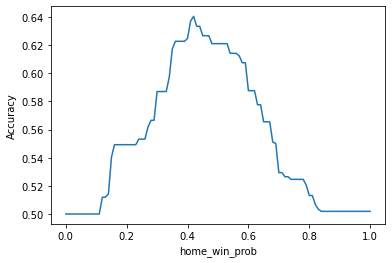

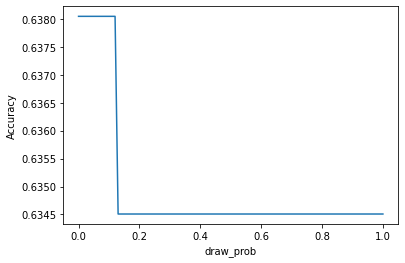

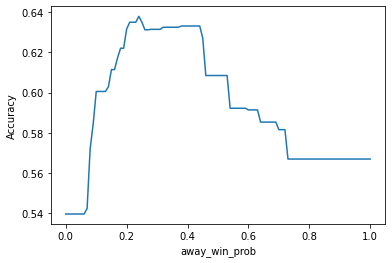

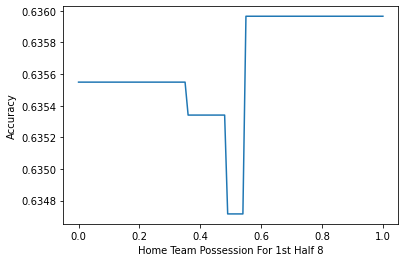

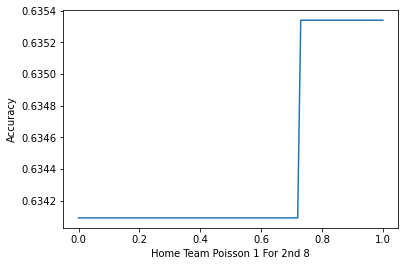

In [77]:
# sensitivity analysis

importances = model_xgboost.feature_importances_

sorted_idx = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {importances[i]}")

feature_names = ['home_win_prob', 'draw_prob', 'away_win_prob', 
                 'Home Team Possession For 1st Half 8', 'Home Team Poisson 1 For 2nd 8']

for feature in feature_names:
    feature_range = np.arange(0, 1.01, 0.01)
    accuracy_scores = []
    for feature_value in feature_range:
        X_valid_temp = X_valid.copy()
        X_valid_temp[feature] = feature_value
        y_pred = model_xgboost.predict(X_valid_temp)
        accuracy = np.mean(y_valid == y_pred)
        accuracy_scores.append(accuracy)
    # plot the results of the sensitivity analysis
    plt.plot(feature_range, accuracy_scores)
    plt.xlabel(feature)
    plt.ylabel('Accuracy')
    plt.show()

Looking at the feature importance list, we see alot of the variables that we saw when we printed our correlations with our target variable. Those variables with 0 importance can be withdrawn from the model in later instances to save on data collection, processing, and training time. We look at the correlation of our predictions and those of the bookies:

In [78]:
print("Corr. between our preds and Bookies: {:.4f}".format(pd.Series(preds).corr(odds.reset_index(drop=True))))

Corr. between our preds and Bookies: 0.9614


This confirms what we suspected earlier. We will remove the highly correlated variables and conduct some further analysis.

In [52]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

target = 'home_win'
correlated_features = set()
corr_matrix = df.corr().abs()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            
            if col1 == target or col2 == target or col1 == 'home_win_prob' or col2 == 'home_win_prob':
                continue
            
            if corr_matrix[col1][target] > corr_matrix[col2][target]:
                
                correlated_features.add(col1)
                
            else:
                
                correlated_features.add(col2)
                
correlated_features
df1 = df_original.drop(list(correlated_features), axis = 1)

In [53]:
targets = ['home_win', 'Draw', 'away_win', 'fhg', 'home_goal', 'away_goal','Country', 'League', 'Kickoff',
          "Home Score", "Away Score", 'Total Goals', 'Over 1.5', 'BTS', "Bucket",
           "fhg", "First Half Home Goals", "First Half Away Goals"]

cols = df_normalised.columns
df1[cols] = df_normalised[cols]

y = df1['home_win']
X = df1.drop(targets, axis = 1)

X_minority = X[y == 1]
y_minority = y[y == 1]
X_majority = X[y == 0]
y_majority = y[y == 0]
X_upsampled, y_upsampled = resample(X_minority, y_minority, replace=True, n_samples=X_majority.shape[0], random_state=42)

X_resampled = pd.concat([X_majority, X_upsampled])
y_resampled = pd.concat([y_majority, y_upsampled])
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [54]:
list(X.columns)

['Draw Full Time Odds',
 'BTS No Full Time Odds',
 'Last Home Game Win',
 '2nd Last Home Game Win',
 '3rd Last Home Game Win',
 '4th Last Home Game Win',
 '5th Last Home Game Win',
 'Last Home Game Loss',
 '2nd Last Home Game Loss',
 '3rd Last Home Game Loss',
 '4th Last Home Game Loss',
 '5th Last Home Game Loss',
 'Last Away Game Win',
 '2nd Last Away Game Win',
 '3rd Last Away Game Win',
 '4th Last Away Game Win',
 '5th Last Away Game Win',
 'Last Away Game Loss',
 '2nd Last Away Game Loss',
 '3rd Last Away Game Loss',
 '4th Last Away Game Loss',
 '5th Last Away Game Loss',
 'Last Home Game Score 0',
 '2nd Last Home Game Score 0',
 '3rd Last Home Game Score 0',
 '4th Last Home Game Score 0',
 '5th Last Home Game Score 0',
 '2nd Last Home Game Score 1',
 '3rd Last Home Game Score 1',
 '4th Last Home Game Score 1',
 '5th Last Home Game Score 1',
 'Last Home Game Score 2',
 '2nd Last Home Game Score 2',
 '3rd Last Home Game Score 2',
 '4th Last Home Game Score 2',
 '5th Last Home Game 

In [55]:
model_xgboost = xgboost.XGBClassifier(learning_rate=0.05,
                                      max_depth=1,
                                      n_estimators=1000,
                                      reg_lambda= 0, 
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_valid, y_valid)]

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=1000,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.62579
[1]	validation_0-auc:0.62868
[2]	validation_0-auc:0.62868
[3]	validation_0-auc:0.62868
[4]	validation_0-auc:0.63044
[5]	validation_0-auc:0.66831
[6]	validation_0-auc:0.66873
[7]	validation_0-auc:0.67524
[8]	validation_0-auc:0.67524
[9]	validation_0-auc:0.67831
[10]	validation_0-auc:0.68149
[11]	validation_0-auc:0.68331


C:\Users\kiera\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-auc:0.68489
[13]	validation_0-auc:0.68767
[14]	validation_0-auc:0.68787
[15]	validation_0-auc:0.68788
[16]	validation_0-auc:0.68847
[17]	validation_0-auc:0.68953
[18]	validation_0-auc:0.69088
[19]	validation_0-auc:0.69107
[20]	validation_0-auc:0.69105
[21]	validation_0-auc:0.69101
[22]	validation_0-auc:0.69101
[23]	validation_0-auc:0.69120
[24]	validation_0-auc:0.69165
[25]	validation_0-auc:0.69164
[26]	validation_0-auc:0.69167
[27]	validation_0-auc:0.69173
[28]	validation_0-auc:0.69172
[29]	validation_0-auc:0.69166
[30]	validation_0-auc:0.69165
[31]	validation_0-auc:0.69165
[32]	validation_0-auc:0.69164
[33]	validation_0-auc:0.69144
[34]	validation_0-auc:0.69144
[35]	validation_0-auc:0.69192
[36]	validation_0-auc:0.69220
[37]	validation_0-auc:0.69220
[38]	validation_0-auc:0.69220
[39]	validation_0-auc:0.69223
[40]	validation_0-auc:0.69224
[41]	validation_0-auc:0.69223
[42]	validation_0-auc:0.69274
[43]	validation_0-auc:0.69275
[44]	validation_0-auc:0.69278
[45]	valid

[280]	validation_0-auc:0.69554
[281]	validation_0-auc:0.69549
[282]	validation_0-auc:0.69550
[283]	validation_0-auc:0.69548
[284]	validation_0-auc:0.69548
[285]	validation_0-auc:0.69543
[286]	validation_0-auc:0.69543
[287]	validation_0-auc:0.69542
[288]	validation_0-auc:0.69551
[289]	validation_0-auc:0.69552
[290]	validation_0-auc:0.69545
[291]	validation_0-auc:0.69550
[292]	validation_0-auc:0.69547
[293]	validation_0-auc:0.69547
[294]	validation_0-auc:0.69547
[295]	validation_0-auc:0.69546
[296]	validation_0-auc:0.69550
[297]	validation_0-auc:0.69554
[298]	validation_0-auc:0.69554
[299]	validation_0-auc:0.69558
[300]	validation_0-auc:0.69560
[301]	validation_0-auc:0.69570
[302]	validation_0-auc:0.69573
[303]	validation_0-auc:0.69575
[304]	validation_0-auc:0.69577
[305]	validation_0-auc:0.69582
[306]	validation_0-auc:0.69581
[307]	validation_0-auc:0.69579
[308]	validation_0-auc:0.69586
[309]	validation_0-auc:0.69586
[310]	validation_0-auc:0.69586
[311]	validation_0-auc:0.69590
[312]	va

[545]	validation_0-auc:0.69769
[546]	validation_0-auc:0.69764
[547]	validation_0-auc:0.69771
[548]	validation_0-auc:0.69770
[549]	validation_0-auc:0.69767
[550]	validation_0-auc:0.69770
[551]	validation_0-auc:0.69773
[552]	validation_0-auc:0.69772
[553]	validation_0-auc:0.69779
[554]	validation_0-auc:0.69778
[555]	validation_0-auc:0.69778
[556]	validation_0-auc:0.69782
[557]	validation_0-auc:0.69781
[558]	validation_0-auc:0.69785
[559]	validation_0-auc:0.69785
[560]	validation_0-auc:0.69778
[561]	validation_0-auc:0.69776
[562]	validation_0-auc:0.69772
[563]	validation_0-auc:0.69773
[564]	validation_0-auc:0.69774
[565]	validation_0-auc:0.69775
[566]	validation_0-auc:0.69772
[567]	validation_0-auc:0.69774
[568]	validation_0-auc:0.69783
[569]	validation_0-auc:0.69783
[570]	validation_0-auc:0.69783
[571]	validation_0-auc:0.69783
[572]	validation_0-auc:0.69779
[573]	validation_0-auc:0.69781
[574]	validation_0-auc:0.69779
[575]	validation_0-auc:0.69779
[576]	validation_0-auc:0.69780
[577]	va

[810]	validation_0-auc:0.69828
[811]	validation_0-auc:0.69830
[812]	validation_0-auc:0.69833
[813]	validation_0-auc:0.69830
[814]	validation_0-auc:0.69829
[815]	validation_0-auc:0.69826
[816]	validation_0-auc:0.69824
[817]	validation_0-auc:0.69825
[818]	validation_0-auc:0.69822
[819]	validation_0-auc:0.69825
[820]	validation_0-auc:0.69826
[821]	validation_0-auc:0.69830
[822]	validation_0-auc:0.69832
[823]	validation_0-auc:0.69829
[824]	validation_0-auc:0.69837
[825]	validation_0-auc:0.69841
[826]	validation_0-auc:0.69845
[827]	validation_0-auc:0.69840
[828]	validation_0-auc:0.69840
[829]	validation_0-auc:0.69840
[830]	validation_0-auc:0.69837
[831]	validation_0-auc:0.69839
[832]	validation_0-auc:0.69840
[833]	validation_0-auc:0.69842
[834]	validation_0-auc:0.69847
[835]	validation_0-auc:0.69845
[836]	validation_0-auc:0.69842
[837]	validation_0-auc:0.69844
[838]	validation_0-auc:0.69846
[839]	validation_0-auc:0.69848
[840]	validation_0-auc:0.69841
[841]	validation_0-auc:0.69842
[842]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0, ...)

In [56]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
preds = model_xgboost.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}".format(roc_auc_score(y_valid, preds)))
print("AUC BOOKIES: {:.4f}\nAUC Validation: {:.4f}".format(roc_auc_score(y_valid, odds),
                                                    roc_auc_score(y_valid, preds)))

print("Corr. between our preds and Bookies: {:.4f}".format(pd.Series(preds).corr(odds.reset_index(drop=True))))

validation_set=y_valid.reset_index(drop = True)

thresholds = [0.25, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, .70, .75, 0.8, 0.85, 0.9]

for t in thresholds:
    preds1 = []
    for i in range(len(preds)):
        if preds[i] >= t:
            preds1.append(1.)
        else:
            preds1.append(0.)
    print(confusion_matrix(validation_set, preds1))
    no = (confusion_matrix(validation_set, preds1)[0][1]+confusion_matrix(validation_set, preds1)[1][1])
    pa = (confusion_matrix(validation_set, preds1)[1][1]/(confusion_matrix(validation_set, preds1)[0][1]+confusion_matrix(validation_set, preds1)[1][1]))
    print(f"If threshold is {t}, accuracy on positive predictions is {round(pa, 2)*100}%, with {no} samples")   

AUC Train: 0.6990
AUC BOOKIES: 0.6937
AUC Validation: 0.6990
Corr. between our preds and Bookies: 0.9646
[[ 377 2022]
 [  77 2323]]
If threshold is 0.25, accuracy on positive predictions is 53.0%, with 4345 samples
[[ 588 1811]
 [ 161 2239]]
If threshold is 0.3, accuracy on positive predictions is 55.00000000000001%, with 4050 samples
[[ 749 1650]
 [ 246 2154]]
If threshold is 0.35, accuracy on positive predictions is 56.99999999999999%, with 3804 samples
[[ 972 1427]
 [ 401 1999]]
If threshold is 0.4, accuracy on positive predictions is 57.99999999999999%, with 3426 samples
[[1301 1098]
 [ 667 1733]]
If threshold is 0.45, accuracy on positive predictions is 61.0%, with 2831 samples
[[1626  773]
 [ 948 1452]]
If threshold is 0.5, accuracy on positive predictions is 65.0%, with 2225 samples
[[1844  555]
 [1201 1199]]
If threshold is 0.55, accuracy on positive predictions is 68.0%, with 1754 samples
[[2002  397]
 [1400 1000]]
If threshold is 0.6, accuracy on positive predictions is 72.0%

In [57]:
for t in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    results = get_profits(odds, preds, t, validation_set)
    print(f"At threshold {t} for predictions: \n Profit: {results[0]} \n Number of bets: {results[1]} \n Return %: {results[2]} \n")
print(get_value_strat1(odds, preds, 0.05, validation_set))
print(get_value_strat2(odds, preds, 0.05, validation_set))

At threshold 0.4 for predictions: 
 Profit: 309.5548158208394 
 Number of bets: 3426 
 Return %: 9.035458722149428 

At threshold 0.45 for predictions: 
 Profit: 225.48545465642852 
 Number of bets: 2831 
 Return %: 7.964869468612805 

At threshold 0.5 for predictions: 
 Profit: 187.06397897488006 
 Number of bets: 2225 
 Return %: 8.407369841567643 

At threshold 0.55 for predictions: 
 Profit: 123.68185371201871 
 Number of bets: 1754 
 Return %: 7.0514169733191965 

At threshold 0.6 for predictions: 
 Profit: 93.75974274639566 
 Number of bets: 1397 
 Return %: 6.711506281059103 

At threshold 0.65 for predictions: 
 Profit: 58.628221539646944 
 Number of bets: 1052 
 Return %: 5.573024861183169 

At threshold 0.7 for predictions: 
 Profit: 17.74653683837027 
 Number of bets: 768 
 Return %: 2.3107469841627957 

At threshold 0.75 for predictions: 
 Profit: 13.345294178067249 
 Number of bets: 523 
 Return %: 2.551681487202151 

(319.7077248957458, 903, 798, 18.795280711096165)
(5.07

Removing the correlated variables has led to a slight decrease in our AUC score but our model still outperforms the bookies. The model is clearly still highly dependent on the bookmakers odds and slightly more so than with our first model. Before going any further we will skip the box cox transformation and create another model. With gradient boosted tree based algorithms it is not generally necessary to have predictors that are normally distributed. We will use only the scaled variables instead and see if there is any difference.

In [58]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

target = 'home_win'
correlated_features = set()
corr_matrix = df.corr().abs()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            
            if col1 == target or col2 == target or col1 == 'home_win_prob' or col2 == 'home_win_prob':
                continue
            
            if corr_matrix[col1][target] > corr_matrix[col2][target]:
                
                correlated_features.add(col1)
                
            else:
                
                correlated_features.add(col2)

df1 = df_original.drop(list(correlated_features), axis = 1)

In [63]:
targets = ['home_win', "Draw", 'away_win', 'fhg', 'home_goal', 'away_goal',
           "Home Score", "Away Score", "Over 1.5", "BTS",'Country', 'League', 'Kickoff',
           "fhg", "First Half Home Goals", "First Half Away Goals",
          'Total Goals','Bucket']

cols = df_scaled.columns

df1[cols] = df_scaled[cols]

y = df1['home_win']
X = df1.drop(targets, axis = 1)

# Upsample minority class
X_minority = X[y == 1]
y_minority = y[y == 1]
X_majority = X[y == 0]
y_majority = y[y == 0]
X_upsampled, y_upsampled = resample(X_minority, y_minority, replace=True, n_samples=X_majority.shape[0], random_state=42)

# Combine majority class with upsampled minority class
X_resampled = pd.concat([X_majority, X_upsampled])
y_resampled = pd.concat([y_majority, y_upsampled])

X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [64]:
list(X.columns)

['Draw Full Time Odds',
 'BTS No Full Time Odds',
 'Last Home Game Win',
 '2nd Last Home Game Win',
 '3rd Last Home Game Win',
 '4th Last Home Game Win',
 '5th Last Home Game Win',
 'Last Home Game Loss',
 '2nd Last Home Game Loss',
 '3rd Last Home Game Loss',
 '4th Last Home Game Loss',
 '5th Last Home Game Loss',
 'Last Away Game Win',
 '2nd Last Away Game Win',
 '3rd Last Away Game Win',
 '4th Last Away Game Win',
 '5th Last Away Game Win',
 'Last Away Game Loss',
 '2nd Last Away Game Loss',
 '3rd Last Away Game Loss',
 '4th Last Away Game Loss',
 '5th Last Away Game Loss',
 'Last Home Game Score 0',
 '2nd Last Home Game Score 0',
 '3rd Last Home Game Score 0',
 '4th Last Home Game Score 0',
 '5th Last Home Game Score 0',
 '2nd Last Home Game Score 1',
 '3rd Last Home Game Score 1',
 '4th Last Home Game Score 1',
 '5th Last Home Game Score 1',
 'Last Home Game Score 2',
 '2nd Last Home Game Score 2',
 '3rd Last Home Game Score 2',
 '4th Last Home Game Score 2',
 '5th Last Home Game 

In [65]:
model_xgboost = xgboost.XGBClassifier(learning_rate=0.05,
                                      max_depth=1,
                                      n_estimators=1000,
                                      reg_lambda= 0, 
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      eval_metric='auc',
                                      verbosity=1)

eval_set = [(X_valid, y_valid)]

model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=1000,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.62579
[1]	validation_0-auc:0.62868
[2]	validation_0-auc:0.62868
[3]	validation_0-auc:0.62868
[4]	validation_0-auc:0.63044
[5]	validation_0-auc:0.66831
[6]	validation_0-auc:0.66873
[7]	validation_0-auc:0.67524
[8]	validation_0-auc:0.67524


C:\Users\kiera\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-auc:0.67831
[10]	validation_0-auc:0.68149
[11]	validation_0-auc:0.68331
[12]	validation_0-auc:0.68489
[13]	validation_0-auc:0.68767
[14]	validation_0-auc:0.68787
[15]	validation_0-auc:0.68788
[16]	validation_0-auc:0.68847
[17]	validation_0-auc:0.68953
[18]	validation_0-auc:0.69088
[19]	validation_0-auc:0.69107
[20]	validation_0-auc:0.69105
[21]	validation_0-auc:0.69101
[22]	validation_0-auc:0.69101
[23]	validation_0-auc:0.69120
[24]	validation_0-auc:0.69165
[25]	validation_0-auc:0.69164
[26]	validation_0-auc:0.69167
[27]	validation_0-auc:0.69173
[28]	validation_0-auc:0.69172
[29]	validation_0-auc:0.69166
[30]	validation_0-auc:0.69165
[31]	validation_0-auc:0.69165
[32]	validation_0-auc:0.69164
[33]	validation_0-auc:0.69144
[34]	validation_0-auc:0.69144
[35]	validation_0-auc:0.69192
[36]	validation_0-auc:0.69220
[37]	validation_0-auc:0.69220
[38]	validation_0-auc:0.69220
[39]	validation_0-auc:0.69223
[40]	validation_0-auc:0.69224
[41]	validation_0-auc:0.69223
[42]	valida

[277]	validation_0-auc:0.69555
[278]	validation_0-auc:0.69557
[279]	validation_0-auc:0.69553
[280]	validation_0-auc:0.69554
[281]	validation_0-auc:0.69549
[282]	validation_0-auc:0.69550
[283]	validation_0-auc:0.69548
[284]	validation_0-auc:0.69548
[285]	validation_0-auc:0.69543
[286]	validation_0-auc:0.69543
[287]	validation_0-auc:0.69542
[288]	validation_0-auc:0.69551
[289]	validation_0-auc:0.69552
[290]	validation_0-auc:0.69545
[291]	validation_0-auc:0.69550
[292]	validation_0-auc:0.69547
[293]	validation_0-auc:0.69547
[294]	validation_0-auc:0.69547
[295]	validation_0-auc:0.69546
[296]	validation_0-auc:0.69550
[297]	validation_0-auc:0.69554
[298]	validation_0-auc:0.69554
[299]	validation_0-auc:0.69558
[300]	validation_0-auc:0.69560
[301]	validation_0-auc:0.69570
[302]	validation_0-auc:0.69573
[303]	validation_0-auc:0.69575
[304]	validation_0-auc:0.69577
[305]	validation_0-auc:0.69582
[306]	validation_0-auc:0.69581
[307]	validation_0-auc:0.69579
[308]	validation_0-auc:0.69586
[309]	va

[542]	validation_0-auc:0.69773
[543]	validation_0-auc:0.69769
[544]	validation_0-auc:0.69766
[545]	validation_0-auc:0.69769
[546]	validation_0-auc:0.69764
[547]	validation_0-auc:0.69771
[548]	validation_0-auc:0.69770
[549]	validation_0-auc:0.69767
[550]	validation_0-auc:0.69770
[551]	validation_0-auc:0.69773
[552]	validation_0-auc:0.69772
[553]	validation_0-auc:0.69779
[554]	validation_0-auc:0.69778
[555]	validation_0-auc:0.69778
[556]	validation_0-auc:0.69782
[557]	validation_0-auc:0.69781
[558]	validation_0-auc:0.69785
[559]	validation_0-auc:0.69785
[560]	validation_0-auc:0.69778
[561]	validation_0-auc:0.69776
[562]	validation_0-auc:0.69772
[563]	validation_0-auc:0.69773
[564]	validation_0-auc:0.69774
[565]	validation_0-auc:0.69775
[566]	validation_0-auc:0.69772
[567]	validation_0-auc:0.69774
[568]	validation_0-auc:0.69783
[569]	validation_0-auc:0.69783
[570]	validation_0-auc:0.69783
[571]	validation_0-auc:0.69783
[572]	validation_0-auc:0.69779
[573]	validation_0-auc:0.69781
[574]	va

[807]	validation_0-auc:0.69824
[808]	validation_0-auc:0.69832
[809]	validation_0-auc:0.69831
[810]	validation_0-auc:0.69828
[811]	validation_0-auc:0.69830
[812]	validation_0-auc:0.69833
[813]	validation_0-auc:0.69830
[814]	validation_0-auc:0.69829
[815]	validation_0-auc:0.69826
[816]	validation_0-auc:0.69824
[817]	validation_0-auc:0.69825
[818]	validation_0-auc:0.69822
[819]	validation_0-auc:0.69825
[820]	validation_0-auc:0.69826
[821]	validation_0-auc:0.69830
[822]	validation_0-auc:0.69832
[823]	validation_0-auc:0.69829
[824]	validation_0-auc:0.69837
[825]	validation_0-auc:0.69841
[826]	validation_0-auc:0.69845
[827]	validation_0-auc:0.69840
[828]	validation_0-auc:0.69840
[829]	validation_0-auc:0.69840
[830]	validation_0-auc:0.69837
[831]	validation_0-auc:0.69839
[832]	validation_0-auc:0.69840
[833]	validation_0-auc:0.69842
[834]	validation_0-auc:0.69847
[835]	validation_0-auc:0.69845
[836]	validation_0-auc:0.69842
[837]	validation_0-auc:0.69844
[838]	validation_0-auc:0.69846
[839]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0, ...)

In [66]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
preds = model_xgboost.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}".format(roc_auc_score(y_valid, preds)))
print("AUC BOOKIES: {:.4f}\nAUC Validation: {:.4f}".format(roc_auc_score(y_valid, odds),
                                                    roc_auc_score(y_valid, preds)))

print("Corr. between our preds and Bookies: {:.4f}".format(pd.Series(preds).corr(odds.reset_index(drop=True))))

validation_set=y_valid.reset_index(drop = True)

thresholds = [0.25, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, .70, .75, 0.8, 0.85, 0.9]

for t in thresholds:
    preds1 = []
    for i in range(len(preds)):
        if preds[i] >= t:
            preds1.append(1.)
        else:
            preds1.append(0.)
    print(confusion_matrix(validation_set, preds1))
    no = (confusion_matrix(validation_set, preds1)[0][1]+confusion_matrix(validation_set, preds1)[1][1])
    pa = (confusion_matrix(validation_set, preds1)[1][1]/(confusion_matrix(validation_set, preds1)[0][1]+confusion_matrix(validation_set, preds1)[1][1]))
    print(f"If threshold is {t}, accuracy on positive predictions is {round(pa, 2)*100}%, with {no} samples")  

AUC Train: 0.6990
AUC BOOKIES: 0.6937
AUC Validation: 0.6990
Corr. between our preds and Bookies: 0.9646
[[ 377 2022]
 [  77 2323]]
If threshold is 0.25, accuracy on positive predictions is 53.0%, with 4345 samples
[[ 588 1811]
 [ 161 2239]]
If threshold is 0.3, accuracy on positive predictions is 55.00000000000001%, with 4050 samples
[[ 749 1650]
 [ 246 2154]]
If threshold is 0.35, accuracy on positive predictions is 56.99999999999999%, with 3804 samples
[[ 972 1427]
 [ 401 1999]]
If threshold is 0.4, accuracy on positive predictions is 57.99999999999999%, with 3426 samples
[[1301 1098]
 [ 667 1733]]
If threshold is 0.45, accuracy on positive predictions is 61.0%, with 2831 samples
[[1626  773]
 [ 948 1452]]
If threshold is 0.5, accuracy on positive predictions is 65.0%, with 2225 samples
[[1844  555]
 [1201 1199]]
If threshold is 0.55, accuracy on positive predictions is 68.0%, with 1754 samples
[[2002  397]
 [1400 1000]]
If threshold is 0.6, accuracy on positive predictions is 72.0%

In [67]:
for t in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    results = get_profits(odds, preds, t, validation_set)
    print(f"At threshold {t} for predictions: \n Profit: {results[0]} \n Number of bets: {results[1]} \n Return %: {results[2]} \n")

print(get_value_strat1(odds, preds, 0.05, validation_set))
print(get_value_strat2(odds, preds, 0.05, validation_set))

At threshold 0.4 for predictions: 
 Profit: 309.5548158208394 
 Number of bets: 3426 
 Return %: 9.035458722149428 

At threshold 0.45 for predictions: 
 Profit: 225.48545465642852 
 Number of bets: 2831 
 Return %: 7.964869468612805 

At threshold 0.5 for predictions: 
 Profit: 187.06397897488006 
 Number of bets: 2225 
 Return %: 8.407369841567643 

At threshold 0.55 for predictions: 
 Profit: 123.68185371201871 
 Number of bets: 1754 
 Return %: 7.0514169733191965 

At threshold 0.6 for predictions: 
 Profit: 93.75974274639566 
 Number of bets: 1397 
 Return %: 6.711506281059103 

At threshold 0.65 for predictions: 
 Profit: 58.628221539646944 
 Number of bets: 1052 
 Return %: 5.573024861183169 

At threshold 0.7 for predictions: 
 Profit: 17.74653683837027 
 Number of bets: 768 
 Return %: 2.3107469841627957 

At threshold 0.75 for predictions: 
 Profit: 13.345294178067249 
 Number of bets: 523 
 Return %: 2.551681487202151 

(319.7077248957458, 903, 798, 18.795280711096165)
(5.07

There is no difference between the models when using normalisation or not. We may be able to skip this step for future models and save time and power. Sensitivity analysis showed us that our model was heavily dependent on the bookies odds and also showed us that many variables were insignificant in their predictive power. We may be able to remove these variables in later use. 

The model with the best performance used the full dataset with scaling and normalisation, and shows that there is a path towards using machine learning to generate soccer match predictions that can outperform the bookmakers and generate profitable betting strategies. But this is just the start. Next, we will build lasso, ridge and random forest classifiers for comparison. We will then optimise the best model and introduce k-fold validation to ensure greater robustness of the final model. We will also further experiment with feature engineering, adapting features used in baseball prediction to our case. Additionally we can scrape more data from a wider variety of leagues. We can also use more advanced statistics like expected goals for/against as well as player statistics, although this would mean limiting the size of our training data to the top leagues only. 